# 0. Import and Download datasets

In [ ]:
# download train and test datasets

!gdown --quiet 1zzUj0CQGYJlqCVH_h1rCxM11QIIrc7Nn
!gdown --quiet 1klSQM0NUdO42fDp2SWBbxMprpwXJOMm8

In [ ]:
import gc
import shutil
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import lilliefors
from random import choices

# 1. Exploratory Data Analysis

## 1.0. Data and task description

**Data Description**<br><br>
___
train.pkl
___


> Dataset for training. The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories: <br><br>
D_* = Delinquency variables<br>
S_* = Spend variables<br>
P_* = Payment variables<br>
B_* = Balance variables<br>
R_* = Risk variables
<br><br>
With the following features being categorical:
B_30, B_38, D_114, D_116, D_117, D_120, D_126, D_63, D_64, D_66, D_68
<br><br>
The "target" is a binary variable for prediction:<br>
0 = no default event<br>
1 = default event

<br>

___
test.pkl
___
> Dataset for submission. Everything are the same as for train.pkl, except for the "target" column.

<br>

**Task Description**

> Based on the data provided:
* Train a machine learning model (the choice of a specific algorithm is yours):
  * Evaluate the quality of the final model (metric for evaluating - ROC AUC)
  * Analyze feature importance (identify the "strongest" features)
* Make a submission for the test file
  * Put the excel file with name "submission.xlsx" into the "data" directory
  * File should contain 2 columns:
    * "customer_ID" - Id for each test customer
    * "score" - probability of default event (probability of belonging to target == 1)

## 1.1. First looking at the data

In [ ]:
# Datasets initialization

df_train = pd.read_pickle('/content/train.pkl')
df_test = pd.read_pickle('/content/test.pkl')

Let's look at the size of the datasets

In [ ]:
df_train.head(5)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-13,0.934570,0.009117,0.009384,1.007812,0.006104,0.135010,0.001604,0.007175,...,NaN,NaN,0.007187,0.004234,0.005085,NaN,0.005810,0.002970,0.008530,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-03-25,0.880371,0.178101,0.034698,1.003906,0.006912,0.165527,0.005550,0.005070,...,NaN,NaN,0.002981,0.007481,0.007874,NaN,0.003284,0.003170,0.008514,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2018-03-12,0.880859,0.009705,0.004284,0.812500,0.006451,NaN,0.003796,0.007195,...,NaN,NaN,0.007381,0.006622,0.000965,NaN,0.002201,0.000834,0.003445,0
3,000084e5023181993c2e1b665ac88dbb1ce9ef621ec537...,2018-03-19,0.824219,0.009773,0.007851,1.001953,0.006886,0.395752,0.002855,0.006134,...,NaN,NaN,0.009399,0.007835,0.000957,NaN,0.009056,0.006943,0.001446,0
4,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2018-03-12,0.477051,0.000467,0.009415,1.008789,0.007774,0.267090,0.006126,0.125977,...,NaN,NaN,0.006012,0.005222,0.000937,NaN,0.009789,0.003704,0.006275,0


In [ ]:
print(f'Train Dataset Shape: {df_train.shape}')
print(f'Test Dataset Shape: {df_test.shape}')

Train Dataset Shape: (368710, 191)
Test Dataset Shape: (90203, 190)


Datasets contain many (without target - 190) features. Built-in methods for EDA (info, describe, and etc.) will not be very informative, so we will have to aggregate some information before displaying it.

In [ ]:
# Count dtypes

df_train.dtypes.value_counts()

float16           177
category            4
object              1
datetime64[ns]      1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
int64               1
dtype: int64

The fact that categories are counted in this way tells us that they contain different types of data and a different number of unique values.

In [ ]:
# Combine categories

df_train.dtypes.astype(str).value_counts()

float16           177
category           11
object              1
datetime64[ns]      1
int64               1
dtype: int64

In [ ]:
# Let's see what kind of object, datetime and int columns are

df_train.select_dtypes(include=['object', 'datetime64[ns]', 'int']).head()

,customer_ID,S_2,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-13,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-03-25,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2018-03-12,0
3,000084e5023181993c2e1b665ac88dbb1ce9ef621ec537...,2018-03-19,0
4,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2018-03-12,0


From customer_ID we will make an index later. Datetime is uninformative feature, it should be removed.

In [ ]:
# Remove S_2 for train and test

df_train.drop(columns='S_2', inplace=True)
df_test.drop(columns='S_2', inplace=True)

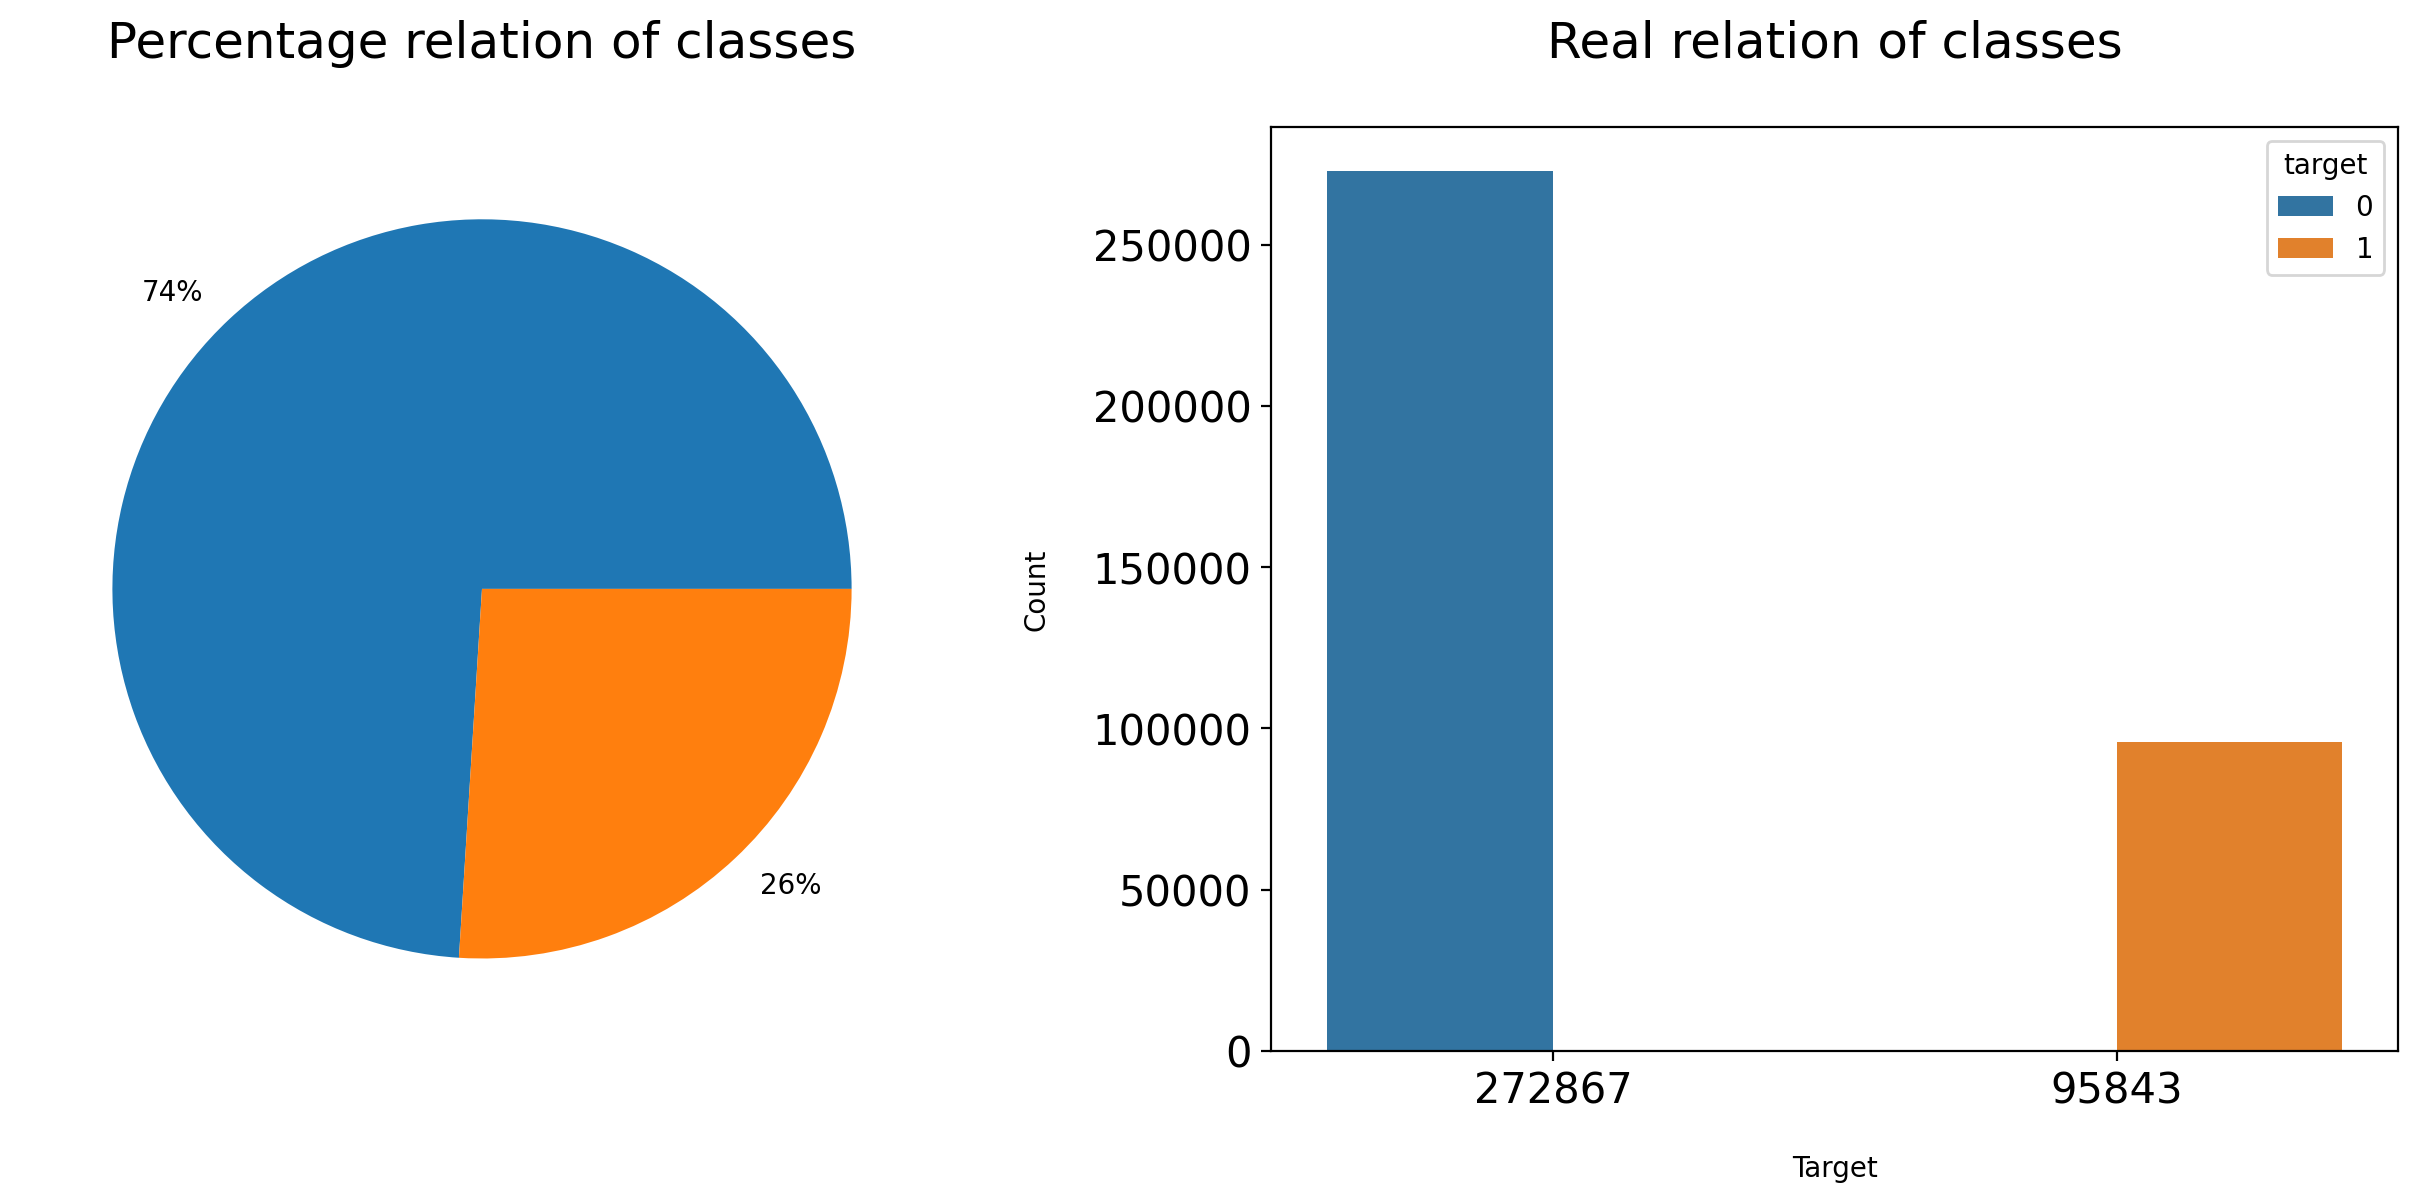

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6), dpi=200)

df_train.groupby('target')['target'].count().plot(kind='pie', ax=axes[0],
                                                  labels=(df_train['target']
                                                  .value_counts(normalize=True)
                                                  .round(2) * 100).astype(int)
                                                  .astype(str) + '%')
sns.countplot(x=df_train['target'], hue=df_train['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_xlabel('Target', labelpad=15)
axes[1].set_ylabel('Count', labelpad=15)
axes[1].set_xticklabels(df_train['target'].value_counts())
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Percentage relation of classes', fontsize=18, pad=25)
axes[1].set_title('Real relation of classes', fontsize=18, pad=25)

plt.show()

There is an imbalance of classes, but it is not critical, since the dataset reflects the true nature of the data. If a company has half of its customers going into default, then it is a bad company. Here the balance of classes is not needed.

Ok, now let's check for duplicates, because by removing duplicates we can also remove some NaNs. So to speak, two rabbits with one shot.

## 1.2. Preprocessing

### 1.2.1. Duplicates

In [ ]:
print('Train Set: Duplicates by all - {}'.format(df_train.duplicated().sum()))
print('Train Set: Duplicates by customer_ID - {}'
      .format(df_train['customer_ID'].duplicated().sum()), end='\n\n')
print('Test Set: Duplicates by all - {}'.format(df_test.duplicated().sum()))
print('Test Set: Duplicates by customer_ID - {}'
      .format(df_test['customer_ID'].duplicated().sum()))

Train Set: Duplicates by all - 0
Train Set: Duplicates by customer_ID - 0

Test Set: Duplicates by all - 0
Test Set: Duplicates by customer_ID - 0


Ok, no duplicates.

In [ ]:
# Now we can set customer_ID as index for train and test

df_train.set_index('customer_ID', inplace=True)
df_test.set_index('customer_ID', inplace=True)

### 1.2.2. Outliers

First, let's remove those columns where there is only one unique value. These columns are not informative.

In [ ]:
# To do this for train and test

mask = df_train.nunique()
print('Train Set: Columns with one unique value: {}'
      .format(mask[mask == 1].index.tolist()), end='\n\n')

df_train.drop(columns=mask[mask == 1].index, inplace=True)

mask = df_test.nunique()
print('Test Set: Columns with one unique value: {}'
      .format(mask[mask == 1].index.tolist()))

df_test.drop(columns=mask[mask == 1].index, inplace=True)

Train Set: Columns with one unique value: ['D_66', 'D_87']

Test Set: Columns with one unique value: ['D_66', 'D_87']


Then, convert 'float16' to 'float', because this format will interfere us to count statistics.

In [ ]:
# For train and test sets respectively

for c in df_train.select_dtypes(include='float16').columns:
  df_train[c] = df_train[c].astype(float)
  df_test[c] = df_test[c].astype(float)

There are many features in datasets, so it is difficult to estimate outliers from them. Therefore, we will conduct a research where we compare the performance of the model on different data that have been cleaned of outliers and those that have not been cleaned.

Now let's clear the float data from outliers. There are a lot of features in order to evaluate them for outliers on the graphs, so we will do the following:
* In features with a normal distribution, we will consider outliers those values that are beyond 3 sigma;
* In features where there is no normal distribution, we will consider as outliers those values that lie outside the interquartile range.

Let's start by checking for a normal distribution. The Lilliefors test was chosen for checking. The decision was made on the basis of the article:
https://towardsdatascience.com/6-ways-to-test-for-a-normal-distribution-which-one-to-use-9dcf47d8fa93.

Shapiro Wilk test is only suitable for N<=5000, so we do not use it, although this test is strong.

In [ ]:
# To check for a normal distribution

float_col = df_train.select_dtypes(include=float).columns
norm_dist_col = []
no_norm_dist_col = []

for c in float_col:
  if lilliefors(df_train[c].dropna())[1] > 0.05:
    norm_dist_col.append(c)
  else:
    no_norm_dist_col.append(c)

print(f'Columns have a normal distribution: {len(norm_dist_col)}')
print(f'Columns without a normal distribution: {len(no_norm_dist_col)}')

Columns have a normal distribution: 0
Columns without a normal distribution: 176


Sadly :) Then we'll use only the interquartile range method.

However, we will conduct another research, where in one data set we will fill in the outliers with the mean, median, and others in the author's method. This method will be called RDBR (Random Distribution By Ratio). The bottom line is this: the percentage of each normal value (not NaN or outliers) will be the probability of filling in that value instead of a specific NaN or outlier. In theory, this should help evenly fill in any distribution.

Let's create class Filler, which will be helpful to fill in nan or outliers.

In [ ]:
class Filler:
  """
  The class contains functions designed to fill nans and outliers, 
  which can be determined by the interquartile range or by the 3-sigma rule.
  
  It also contains the author's method for filling NaN and outliers - RDBR 
  (Random Distribution By Ratio). The bottom line is this: 
  the percentage of each normal value (not NaN or outliers) will be 
  the probability of filling in that value instead of a specific NaN 
  or outlier. In theory, this should help evenly fill in any distribution.

  Input: 
    data -  pd.DataFrame;
    columns - pd.Index, list or tuple.
  Output:
    Instance of class.
  """

  def __init__(self, 
               data: pd.DataFrame = None,
               columns: pd.Index | list | tuple = None) -> None:
    # Errors
    if type(data) != type(pd.DataFrame()):
      raise TypeError(
          "Required positional argument 'data' must be pd.DataFrame")
      
    if type(columns) not in [type(pd.Index([])), list, tuple]:
      raise TypeError(
          "Required positional argument 'columns' must be pd.Index,"
          + " list or tuple")
      
    # Attributes
    self.data = data.copy(deep=True)
    self.columns = columns


  def fillnan(self, method: str | int | float = 'rdbr') -> pd.DataFrame:
    """
    This method fill in the NaN.

    Input:
      method - NaN filling method takes any int and float, 
               or only 'mean', 'median', 'mode' and 'rdbr'.
    Output:
      pd.Dataframe.
    """

    # Errors
    if type(method) not in [str, int, float]:
      raise TypeError(
          "Required positional argument 'method' must be str, int or float")
      
    if type(method) == str:
      if method not in ['mean', 'median', 'mode', 'rdbr']:
        raise ValueError(
            "If Required positional argument 'method' is str, then it accepts"
            + " only one of these values: 'mean', 'median', 'mode' or 'rdbr'")
    
    # Code
    for c in self.columns:
      nans = self.data[c].isna()

      if type(method) == int or type(method) == float:
        self.data.loc[nans, c] = method

      if method == 'mean':
        self.data.loc[nans, c] = self.data[c].mean()

      if method == 'median':
        self.data.loc[nans, c] = self.data[c].median()

      if method == 'mode':
        self.data.loc[nans, c] = self.data[c].mode()[0]

      if method == 'rdbr':
        ratio = self.data[c].value_counts(normalize=True)
        rdbr = ([choices(ratio.index, ratio.values)
                for _ in range(nans.sum())])
        self.data.loc[nans, c] = rdbr
    
    return self.data


  def filloutlier_iqr(self,
                 method: str | int | float = 'rdbr',
                 k: int | float = 1.5) -> pd.DataFrame:
    """
    This method fill in the outliers by the interquartile range.

    Input:
      method - outliers filling method takes any int and float, 
               or only 'mean', 'median' and 'rdbr';
      k - interquartile range multiplier takes any int or float.
    Output:
      pd.Dataframe.
    """

    # Errors
    if type(method) not in [str, int, float]:
      raise TypeError(
          "Required positional argument 'method' must be str, int or float")
      
    if type(k) not in [int, float]:
      raise TypeError(
          "Required positional argument 'k' must be int or float")
      
    if type(method) == str:
      if method not in ['mean', 'median', 'rdbr']:
        raise ValueError(
            "If Required positional argument 'method' is str, then it accepts"
            + " only one of these values: 'mean', 'median' or 'rdbr'")

    # Code
    for c in self.columns:
      q1, q3 = self.data[c].quantile(0.25), self.data[c].quantile(0.75)
      iqr = k * (q3 - q1)
      left, right = q1 - iqr, q3 + iqr
      outliers = (self.data[c] < left) | (self.data[c] > right)
      no_outliers = self.data.loc[~outliers, c]

      if type(method) == int or type(method) == float:
        self.data.loc[outliers, c] = method

      if method == 'mean':
        self.data.loc[outliers, c] = no_outliers.mean()

      if method == 'median':
        self.data.loc[outliers, c] = no_outliers.median()
      
      if method == 'rdbr':
        ratio = no_outliers.value_counts(normalize=True)
        rdbr = ([choices(ratio.index, ratio.values)
                 for _ in range(self.data.loc[outliers, c].size)])
        self.data.loc[outliers, c] = rdbr
      
    return self.data


  def filloutlier_sigma(self, 
                   method: str | int | float = 'rdbr',
                   k: int | float = 3) -> pd.DataFrame:
    """
    This method fill in the outliers by the 3-sigma rule.

    Input:
      method - outliers filling method takes any int and float, 
               or only 'mean', 'median' and 'rdbr';
      k - sigma multiplier takes any int or float.
    Output:
      pd.Dataframe.
    """

    # Errors
    if type(method) not in [str, int, float]:
      raise TypeError(
          "Required positional argument 'method' must be str, int or float")
    
    if type(k) not in [int, float]:
      raise TypeError(
          "Required positional argument 'k' must be int or float")
    
    if type(method) == str:
      if method not in ['mean', 'median', 'rdbr']:
        raise ValueError(
            "If Required positional argument 'method' is str, then it accepts"
            + " only one of these values: 'mean', 'median' or 'rdbr'")

    # Code
    for c in self.columns:
      mean, sigma = self.data[c].mean(), k * self.data[c].std()
      left, right = mean - sigma, mean + sigma
      outliers = (self.data[c] < left) | (self.data[c] > right)
      no_outliers = self.data.loc[~outliers, c]

      if type(method) == int or type(method) == float:
        self.data.loc[outliers, c] = method

      if method == 'mean':
        self.data.loc[outliers, c] = no_outliers.mean()

      if method == 'median':
        self.data.loc[outliers, c] = no_outliers.median()
      
      if method == 'rdbr':
        ratio = no_outliers.value_counts(normalize=True)
        rdbr = ([choices(ratio.index, ratio.values)
                 for _ in range(self.data.loc[outliers, c].size)])
        self.data.loc[outliers, c] = rdbr
      
    return self.data

Let's replace outliers with different statistics for train and test sets

In [ ]:
%%time

# mean
filler = Filler(df_train, float_col)
df_train_withoutliers_mean = filler.filloutlier_iqr('mean')
filler = Filler(df_test, float_col)
df_test_withoutliers_mean = filler.filloutlier_iqr('mean')

CPU times: user 5.22 s, sys: 315 ms, total: 5.54 s
Wall time: 5.54 s


In [ ]:
%time

# median
filler = Filler(df_train, float_col)
df_train_withoutliers_median = filler.filloutlier_iqr('median')
filler = Filler(df_test, float_col)
df_test_withoutliers_median = filler.filloutlier_iqr('median')

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs


In [ ]:
%%time

# rdbr
filler = Filler(df_train, float_col)
df_train_withoutliers_rdbr = filler.filloutlier_iqr('rdbr')
filler = Filler(df_test, float_col)
df_test_withoutliers_rdbr = filler.filloutlier_iqr('rdbr')

CPU times: user 44min 59s, sys: 5.6 s, total: 45min 5s
Wall time: 46min 7s


The RDBR method is very computationally expensive. It remains to be hoped for its results in the future.

In [ ]:
# Clean memory

del mask, fig, axes, c
del float_col, norm_dist_col, no_norm_dist_col, filler
gc.collect()

45

Now, it's NaN's turn :)

#### 1.2.2.0. Checkpoint

We save the datasets as a zip-file, since the operations to clean up outliers take about an hour. We need to be able to quickly return in case of emergency.

In [ ]:
# Saving

!mkdir saved

# Original
df_train.to_pickle('/content/saved/train_original.pkl')
df_test.to_pickle('/content/saved/test_original.pkl')

# Mean
df_train_withoutliers_mean.to_pickle('/content/saved/train_withoutliers_mean.pkl')
df_test_withoutliers_mean.to_pickle('/content/saved/test_withoutliers_mean.pkl')

# Median
df_train_withoutliers_median.to_pickle('/content/saved/train_withoutliers_median.pkl')
df_test_withoutliers_median.to_pickle('/content/saved/test_withoutliers_median.pkl')

# RDBR
df_train_withoutliers_rdbr.to_pickle('/content/saved/train_withoutliers_rdbr.pkl')
df_test_withoutliers_rdbr.to_pickle('/content/saved/test_withoutliers_rdbr.pkl')

!zip -r --quiet /content/checkpoint_outliers.zip /content/saved/

!rm /content/saved/*
!rmdir /content/saved

drive.mount('/content/gdrive')
shutil.move('/content/checkpoint_outliers.zip', '/content/gdrive/MyDrive/')

### 1.2.3. Missing values

#### 1.2.3.0. Start from checkpoint

In [ ]:
# Download and unzip checkpoint_outliers
!gdown --quiet 1-0KGknt5j4kT-60m7HVB_yfm5Xh1hhNn
!unzip -q checkpoint_outliers.zip

# Remove zip
!rm /content/checkpoint_outliers.zip

In [ ]:
# Download our class Filler() as module

!wget --quiet https://raw.githubusercontent.com/Sersalam/Useful_modules/master/filler.py

In [ ]:
import gc
import shutil
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from filler import *

<module 'filler' from '/content/filler.py'>

In [ ]:
# Organizing folders
shutil.move('/content/content/saved', '/content')
!rmdir /content/content

In [ ]:
# Datasets initialization

# Original
df_train = pd.read_pickle('/content/saved/train_original.pkl')
df_test = pd.read_pickle('/content/saved/test_original.pkl')

# Mean
df_train_withoutliers_mean = pd.read_pickle('/content/saved/train_withoutliers_mean.pkl')
df_test_withoutliers_mean = pd.read_pickle('/content/saved/test_withoutliers_mean.pkl')

# Median
df_train_withoutliers_median = pd.read_pickle('/content/saved/train_withoutliers_median.pkl')
df_test_withoutliers_median = pd.read_pickle('/content/saved/test_withoutliers_median.pkl')

# RDBR
df_train_withoutliers_rdbr = pd.read_pickle('/content/saved/train_withoutliers_rdbr.pkl')
df_test_withoutliers_rdbr = pd.read_pickle('/content/saved/test_withoutliers_rdbr.pkl')

#### 1.2.3.1. To the chapter

In [ ]:
# Create condition masks for train and test

train_nans = df_train.isna().sum()
train_nans = train_nans[train_nans > 0]

test_nans = df_test.isna().sum()
test_nans = test_nans[test_nans > 0]

In [ ]:
# Check for different columns with NaN

print('Count different columns with NaN: {}'
      .format(len(train_nans) - len(test_nans)), end='\n\n')
print('Name and values different columns with NaN:')
diff_nan_col = train_nans[~train_nans.index.isin(test_nans.index)]
diff_nan_col

Count different columns with NaN: 16

Name and values different columns with NaN:


B_2      31
D_41     31
B_3      31
D_45     31
D_54     31
B_16     31
B_19     31
B_20     31
B_22     31
B_26     31
B_27     31
B_30     31
B_33     31
B_38     31
D_109    31
D_112    31
dtype: int64

Train and test sets have different columns with NaN. We will visualize according to train dataset, because different columns is non-critical, otherwise train and test sets are the same.

In [ ]:
# Separate columns with missing values by quartile

nans_q1 = train_nans[train_nans/len(df_train) <= 0.25].copy()
nans_q2 = (train_nans
 [(train_nans/len(df_train) > 0.25) & (train_nans/len(df_train) <= 0.5)].copy())
nans_q3 = (train_nans
 [(train_nans/len(df_train) > 0.5) & (train_nans/len(df_train) <= 0.75)].copy())
nans_q4 = (train_nans
 [(train_nans/len(df_train) > 0.75) & (train_nans/len(df_train) <= 1)].copy())

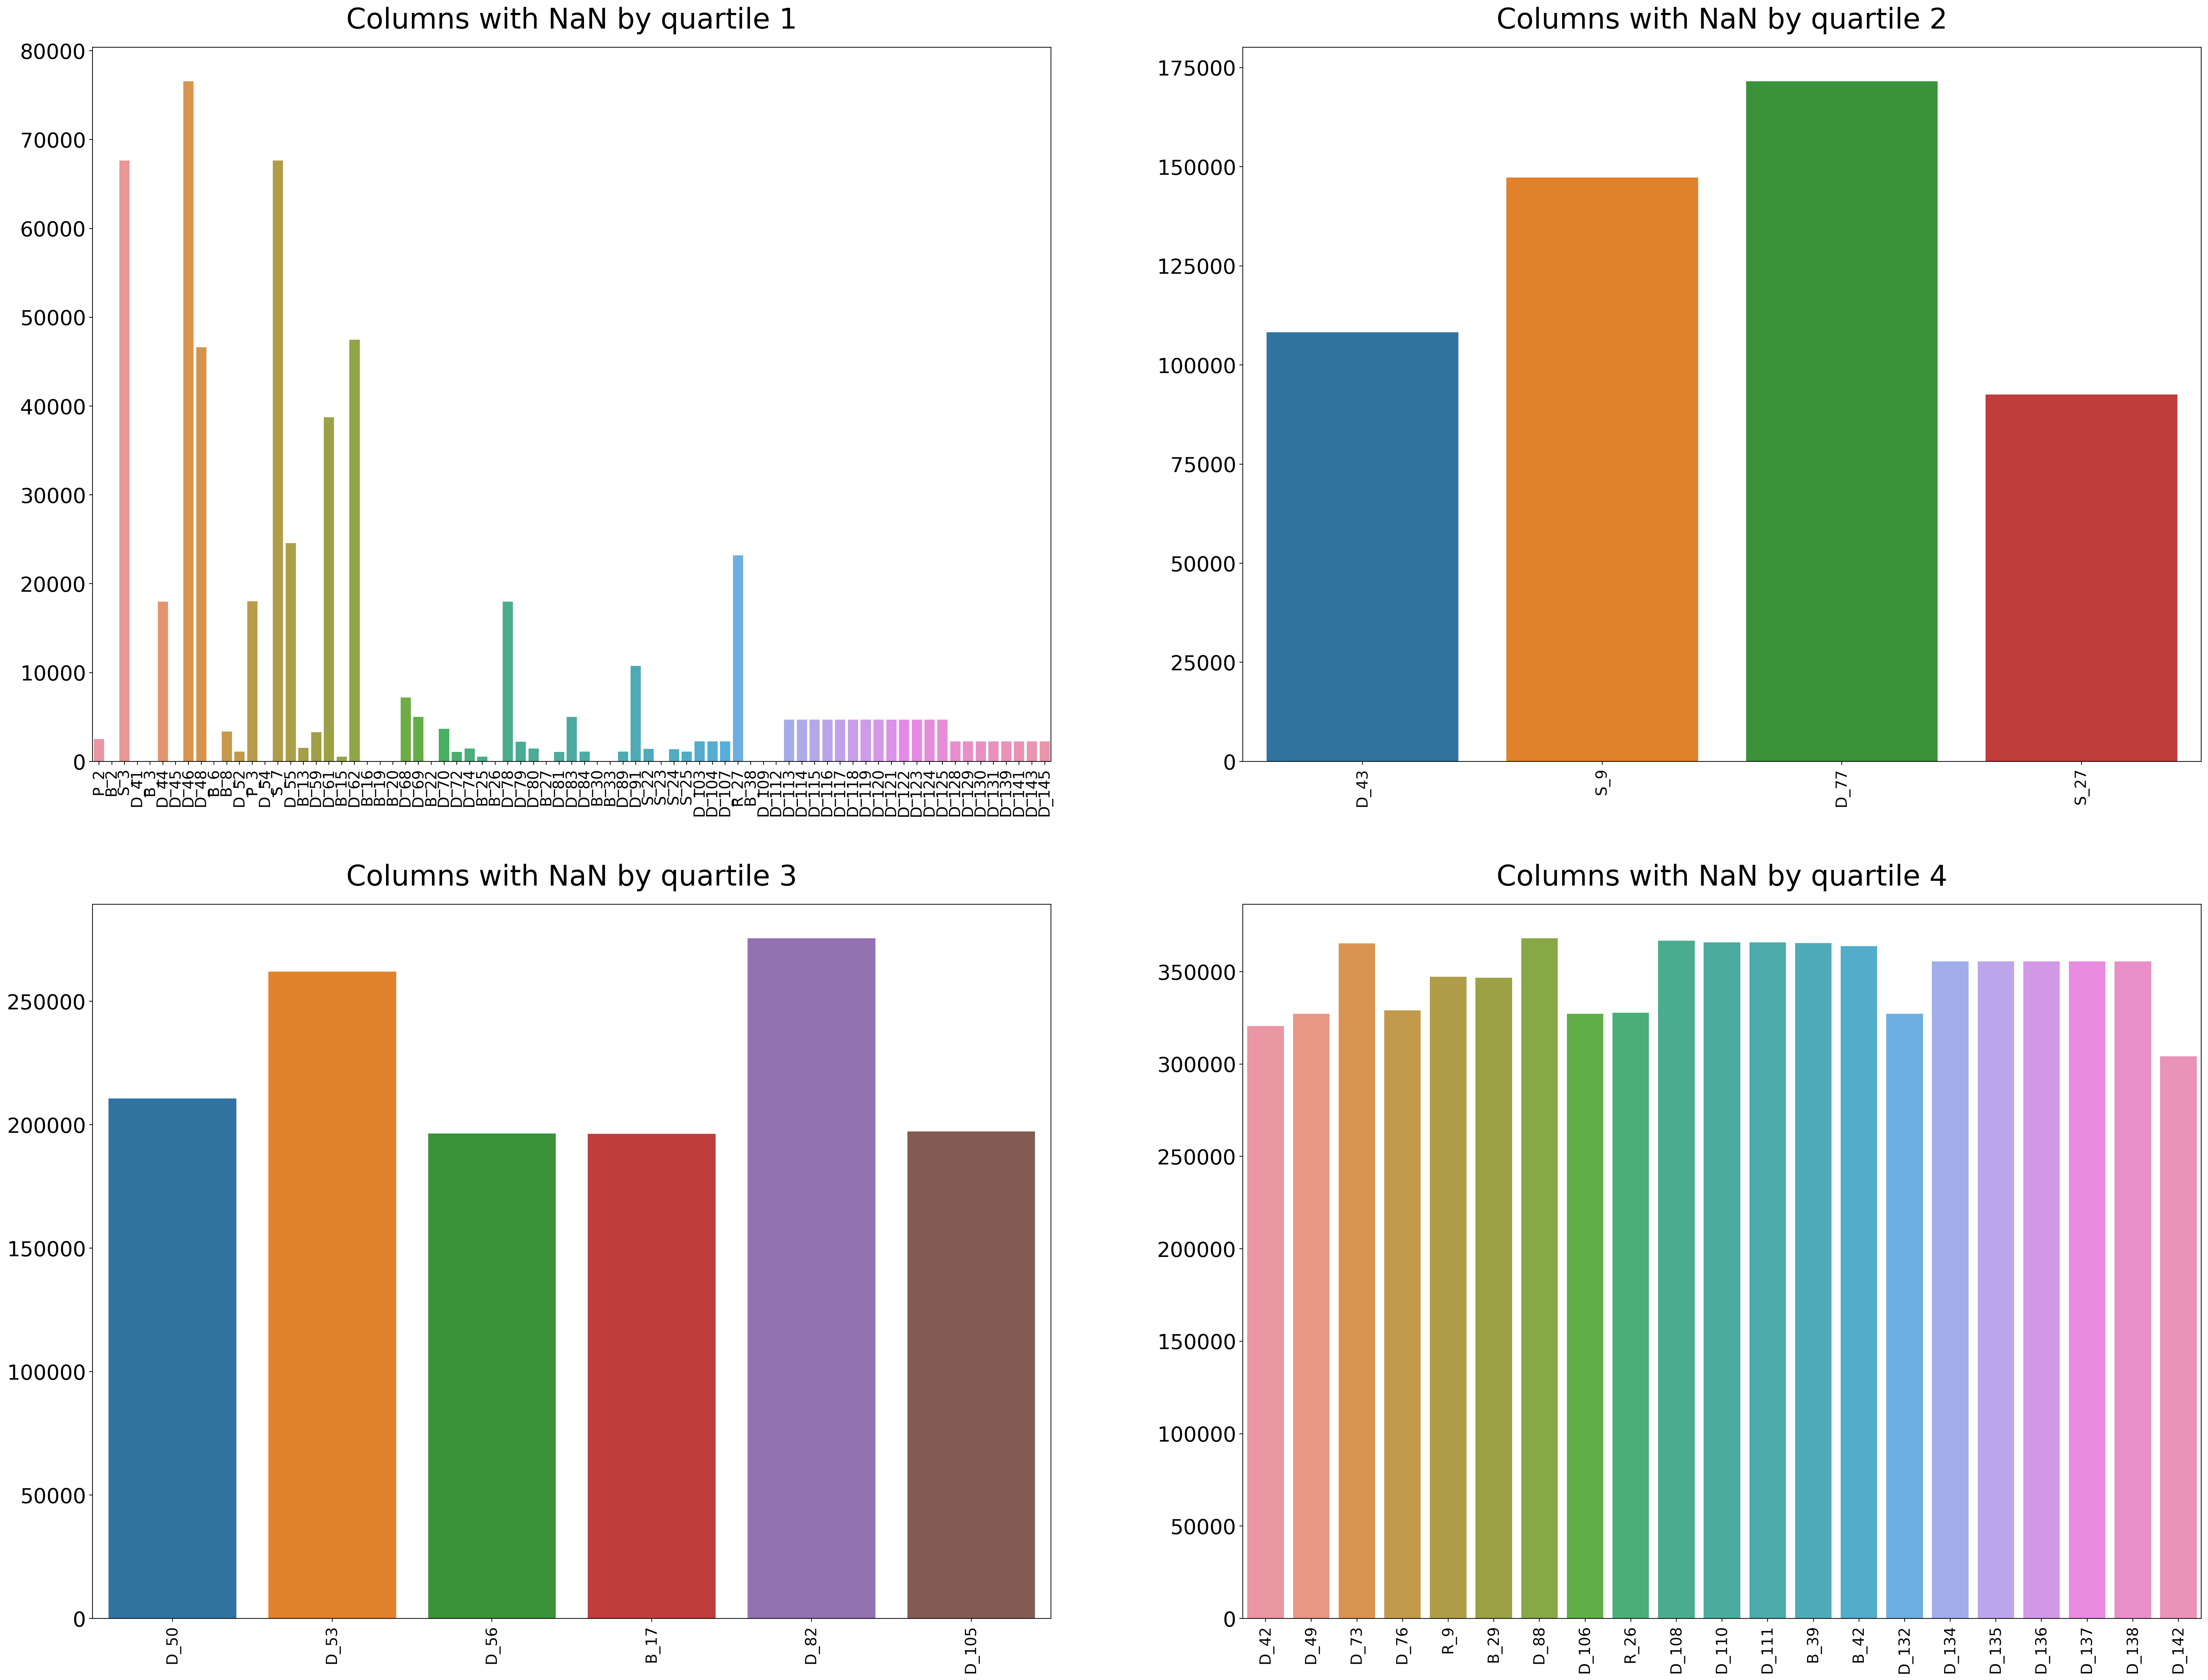

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(40, 30), dpi=200)

sns.barplot(x=nans_q1.index, y=nans_q1.values, ax=axes[0][0])
sns.barplot(x=nans_q2.index, y=nans_q2.values, ax=axes[0][1])
sns.barplot(x=nans_q3.index, y=nans_q3.values, ax=axes[1][0])
sns.barplot(x=nans_q4.index, y=nans_q4.values, ax=axes[1][1])

n = 1
for i in range(2):
  for j in range(2):
    axes[i][j].tick_params(axis='x', labelsize=16, labelrotation=90)
    axes[i][j].tick_params(axis='y', labelsize=22)
    axes[i][j].set_title(f'Columns with NaN by quartile {i + j + n}',
                       fontsize=30, pad=20)
  n += 1

plt.show()

As we can see, most of missing values are in the first quartile, which means we can fill them in. Also, we can fill in NaN in the second quartile. But in 3-th and 4-th, filling in NaN is not possible. Perhaps, if they have categorical features, we can restore them.

In [ ]:
print('Check for categorical features in quartile 3: \n{}'
.format(df_train[nans_q3.index].select_dtypes(include='category').columns),
end='\n\n')
print('Check for categorical features in quartile 4: \n{}'
.format(df_train[nans_q4.index].select_dtypes(include='category').columns),
end='\n\n')

Check for categorical features in quartile 3: 
Index([], dtype='object')

Check for categorical features in quartile 4: 
Index([], dtype='object')



Unfortunately, there is nothing to restore here.

In [ ]:
# To remove 3 and 4 quartiles with NaN for train and test

# Original datasets 
df_train.drop(columns=nans_q3.index.append(nans_q4.index), inplace=True)
df_test.drop(columns=nans_q3.index.append(nans_q4.index), inplace=True)

# Datasets without outliers by mean
df_train_withoutliers_mean.drop(columns=nans_q3.index.append(nans_q4.index),
                                inplace=True)
df_test_withoutliers_mean.drop(columns=nans_q3.index.append(nans_q4.index),
                               inplace=True)

# Datasets without outliers by median
df_train_withoutliers_median.drop(columns=nans_q3.index.append(nans_q4.index),
                                  inplace=True)
df_test_withoutliers_median.drop(columns=nans_q3.index.append(nans_q4.index),
                                 inplace=True)

# Datasets without outliers by rdbr
df_train_withoutliers_rdbr.drop(columns=nans_q3.index.append(nans_q4.index),
                                inplace=True)
df_test_withoutliers_rdbr.drop(columns=nans_q3.index.append(nans_q4.index),
                               inplace=True)

First, to create lists of columns witn NaN by float and categories

In [ ]:
# Train columns witn nan by q1 and q2
train_nan_col = nans_q1.index.append(nans_q2.index)

# Test columns witn nan by q1 and q2
test_nan_col = nans_q1.index.append(nans_q2.index).drop(diff_nan_col.index)

# Train columns with nan by float and categories
train_nan_float_col = (
    df_train[train_nan_col].select_dtypes(include=float).columns)
train_nan_cat_col = (
    df_train[train_nan_col].select_dtypes(include='category').columns)

# Test columns with nan by float and categories
test_nan_float_col = (
    df_test[test_nan_col].select_dtypes(include=float).columns)
test_nan_cat_col = (
    df_test[test_nan_col].select_dtypes(include='category').columns)

We fill the float columns with the mean and the median, and the category features with the mode. RDBR is exception, it populates all data types.

In [ ]:
%%time

# Original datasets (mean)

# Train
filler = Filler(df_train, train_nan_float_col)
df_train_mean = filler.fillnan('mean')
filler = Filler(df_train_mean, train_nan_cat_col)
df_train_mean = filler.fillnan('mode')

# Test
filler = Filler(df_test, test_nan_float_col)
df_test_mean = filler.fillnan('mean')
filler = Filler(df_test_mean, test_nan_cat_col)
df_test_mean = filler.fillnan('mode')

CPU times: user 957 ms, sys: 550 ms, total: 1.51 s
Wall time: 2.08 s


In [ ]:
%%time

# Original datasets (median)

# Train
filler = Filler(df_train, train_nan_float_col)
df_train_median = filler.fillnan('median')
filler = Filler(df_train_median, train_nan_cat_col)
df_train_median = filler.fillnan('mode')

# Test
filler = Filler(df_test, test_nan_float_col)
df_test_median = filler.fillnan('median')
filler = Filler(df_test_median, test_nan_cat_col)
df_test_median = filler.fillnan('mode')

CPU times: user 1.63 s, sys: 679 ms, total: 2.31 s
Wall time: 3.06 s


In [ ]:
%%time

# Original datasets (rdbr)

# Train
filler = Filler(df_train, train_nan_col)
df_train_rdbr = filler.fillnan('rdbr')

# Test
filler = Filler(df_test, test_nan_col)
df_test_rdbr = filler.fillnan('rdbr')

CPU times: user 27min 39s, sys: 2.39 s, total: 27min 41s
Wall time: 31min 8s


In [ ]:
%%time

# Datasets without outliers by mean (mean)

# Train
filler = Filler(df_train_withoutliers_mean, train_nan_float_col)
df_train_withoutliers_mean_mean = filler.fillnan('mean')
filler = Filler(df_train_withoutliers_mean_mean, train_nan_cat_col)
df_train_withoutliers_mean_mean = filler.fillnan('mode')

# Test
filler = Filler(df_test_withoutliers_mean, test_nan_float_col)
df_test_withoutliers_mean_mean = filler.fillnan('mean')
filler = Filler(df_test_withoutliers_mean_mean, test_nan_cat_col)
df_test_withoutliers_mean_mean = filler.fillnan('mode')

CPU times: user 763 ms, sys: 803 ms, total: 1.57 s
Wall time: 1.6 s


In [ ]:
%%time

# Datasets without outliers by mean (median)

# Train
filler = Filler(df_train_withoutliers_mean, train_nan_float_col)
df_train_withoutliers_mean_median = filler.fillnan('median')
filler = Filler(df_train_withoutliers_mean_median, train_nan_cat_col)
df_train_withoutliers_mean_median = filler.fillnan('mode')

# Test
filler = Filler(df_test_withoutliers_mean, test_nan_float_col)
df_test_withoutliers_mean_median = filler.fillnan('median')
filler = Filler(df_test_withoutliers_mean_median, test_nan_cat_col)
df_test_withoutliers_mean_median = filler.fillnan('mode')

CPU times: user 1.41 s, sys: 633 ms, total: 2.05 s
Wall time: 2.27 s


In [ ]:
%%time

# Datasets without outliers by mean (rdbr)

# Train
filler = Filler(df_train_withoutliers_mean, train_nan_col)
df_train_withoutliers_mean_rdbr = filler.fillnan('rdbr')

# Test
filler = Filler(df_test_withoutliers_mean, test_nan_col)
df_test_withoutliers_mean_rdbr = filler.fillnan('rdbr')

CPU times: user 20min 52s, sys: 3.02 s, total: 20min 55s
Wall time: 22min 14s


In [ ]:
%%time

# Datasets without outliers by median (mean)

# Train
filler = Filler(df_train_withoutliers_median, train_nan_float_col)
df_train_withoutliers_median_mean = filler.fillnan('mean')
filler = Filler(df_train_withoutliers_median_mean, train_nan_cat_col)
df_train_withoutliers_median_mean = filler.fillnan('mode')

# Test
filler = Filler(df_test_withoutliers_median, test_nan_float_col)
df_test_withoutliers_median_mean = filler.fillnan('mean')
filler = Filler(df_test_withoutliers_median_mean, test_nan_cat_col)
df_test_withoutliers_median_mean = filler.fillnan('mode')

CPU times: user 794 ms, sys: 1.13 s, total: 1.92 s
Wall time: 1.95 s


In [ ]:
%%time

# Datasets without outliers by median (median)

# Train
filler = Filler(df_train_withoutliers_median, train_nan_float_col)
df_train_withoutliers_median_median = filler.fillnan('median')
filler = Filler(df_train_withoutliers_median_median, train_nan_cat_col)
df_train_withoutliers_median_median = filler.fillnan('mode')

# Test
filler = Filler(df_test_withoutliers_median, test_nan_float_col)
df_test_withoutliers_median_median = filler.fillnan('median')
filler = Filler(df_test_withoutliers_median_median, test_nan_cat_col)
df_test_withoutliers_median_median = filler.fillnan('mode')

CPU times: user 1.37 s, sys: 588 ms, total: 1.95 s
Wall time: 1.99 s


In [ ]:
%%time

# Datasets without outliers by median (rdbr)

# Train
filler = Filler(df_train_withoutliers_median, train_nan_col)
df_train_withoutliers_median_rdbr = filler.fillnan('rdbr')

# Test
filler = Filler(df_test_withoutliers_median, test_nan_col)
df_test_withoutliers_median_rdbr = filler.fillnan('rdbr')

CPU times: user 19min 41s, sys: 2.59 s, total: 19min 43s
Wall time: 19min 51s


In [ ]:
%%time

# Datasets without outliers by rdbr (mean)

# Train
filler = Filler(df_train_withoutliers_rdbr, train_nan_float_col)
df_train_withoutliers_rdbr_mean = filler.fillnan('mean')
filler = Filler(df_train_withoutliers_rdbr_mean, train_nan_cat_col)
df_train_withoutliers_rdbr_mean = filler.fillnan('mode')

# Test
filler = Filler(df_test_withoutliers_rdbr, test_nan_float_col)
df_test_withoutliers_rdbr_mean = filler.fillnan('mean')
filler = Filler(df_test_withoutliers_rdbr_mean, test_nan_cat_col)
df_test_withoutliers_rdbr_mean = filler.fillnan('mode')

CPU times: user 786 ms, sys: 1.39 s, total: 2.17 s
Wall time: 2.21 s


In [ ]:
%%time

# Datasets without outliers by rdbr (median)

# Train
filler = Filler(df_train_withoutliers_rdbr, train_nan_float_col)
df_train_withoutliers_rdbr_median = filler.fillnan('median')
filler = Filler(df_train_withoutliers_rdbr_median, train_nan_cat_col)
df_train_withoutliers_rdbr_median = filler.fillnan('mode')

# Test
filler = Filler(df_test_withoutliers_rdbr, test_nan_float_col)
df_test_withoutliers_rdbr_median = filler.fillnan('median')
filler = Filler(df_test_withoutliers_rdbr_median, test_nan_cat_col)
df_test_withoutliers_rdbr_median = filler.fillnan('mode')

CPU times: user 1.41 s, sys: 2.15 s, total: 3.56 s
Wall time: 3.63 s


In [ ]:
%%time

# Datasets without outliers by rdbr (rdbr)

# Train
filler = Filler(df_train_withoutliers_rdbr, train_nan_col)
df_train_withoutliers_rdbr_rdbr = filler.fillnan('rdbr')

# Test
filler = Filler(df_test_withoutliers_rdbr, test_nan_col)
df_test_withoutliers_rdbr_rdbr = filler.fillnan('rdbr')

CPU times: user 19min 50s, sys: 3.01 s, total: 19min 53s
Wall time: 20min 2s


In [ ]:
print('TRAIN: Remaining nan in origin (mean) - {}'
      .format(df_train_mean.isna().sum().sum()))
print('TEST: Remaining nan in origin (mean) - {}'
      .format(df_test_mean.isna().sum().sum()), end='\n\n')

print('TRAIN: Remaining nan in origin (median) - {}'
      .format(df_train_median.isna().sum().sum()))
print('TEST: Remaining nan in origin (median) - {}'
      .format(df_test_median.isna().sum().sum()), end='\n\n')

print('TRAIN: Remaining nan in origin (rdbr) - {}'
      .format(df_train_rdbr.isna().sum().sum()))
print('TEST: Remaining nan in origin (rdbr) - {}'
      .format(df_test_rdbr.isna().sum().sum()), end='\n\n')

print('TRAIN: Remaining nan in without outliers by mean (mean) - {}'
      .format(df_train_withoutliers_mean_mean.isna().sum().sum()))
print('TEST: Remaining nan in without outliers by mean (mean) - {}'
      .format(df_test_withoutliers_mean_mean.isna().sum().sum()), end='\n\n')

print('TRAIN: Remaining nan in without outliers by mean (median) - {}'
      .format(df_train_withoutliers_mean_median.isna().sum().sum()))
print('TEST: Remaining nan in without outliers by mean (median) - {}'
      .format(df_test_withoutliers_mean_median.isna().sum().sum()), end='\n\n')

print('TRAIN: Remaining nan in without outliers by mean (rdbr) - {}'
      .format(df_train_withoutliers_mean_rdbr.isna().sum().sum()))
print('TEST: Remaining nan in without outliers by mean (rdbr) - {}'
      .format(df_test_withoutliers_mean_rdbr.isna().sum().sum()), end='\n\n')

print('TRAIN: Remaining nan in without outliers by median (mean) - {}'
      .format(df_train_withoutliers_median_mean.isna().sum().sum()))
print('TEST: Remaining nan in without outliers by median (mean) - {}'
      .format(df_test_withoutliers_median_mean.isna().sum().sum()), end='\n\n')

print('TRAIN: Remaining nan in without outliers by median (median) - {}'
      .format(df_train_withoutliers_median_median.isna().sum().sum()))
print('TEST: Remaining nan in without outliers by median (median) - {}'
      .format(df_test_withoutliers_median_median.isna().sum().sum()),
      end='\n\n')

print('TRAIN: Remaining nan in without outliers by median (rdbr) - {}'
      .format(df_train_withoutliers_median_rdbr.isna().sum().sum()))
print('TEST: Remaining nan in without outliers by median (rdbr) - {}'
      .format(df_test_withoutliers_median_rdbr.isna().sum().sum()), end='\n\n')

print('TRAIN: Remaining nan in without outliers by rdbr (mean) - {}'
      .format(df_train_withoutliers_rdbr_mean.isna().sum().sum()))
print('TEST: Remaining nan in without outliers by rdbr (mean) - {}'
      .format(df_test_withoutliers_rdbr_mean.isna().sum().sum()), end='\n\n')

print('TRAIN: Remaining nan in without outliers by rdbr (median) - {}'
      .format(df_train_withoutliers_rdbr_median.isna().sum().sum()))
print('TEST: Remaining nan in without outliers by rdbr (median) - {}'
      .format(df_test_withoutliers_rdbr_median.isna().sum().sum()), end='\n\n')

print('TRAIN: Remaining nan in without outliers by rdbr (rdbr) - {}'
      .format(df_train_withoutliers_rdbr_rdbr.isna().sum().sum()))
print('TEST: Remaining nan in without outliers by rdbr (rdbr) - {}'
      .format(df_test_withoutliers_rdbr_rdbr.isna().sum().sum()), end='\n\n')

TRAIN: Remaining nan in origin (mean) - 0
TEST: Remaining nan in origin (mean) - 0

TRAIN: Remaining nan in origin (median) - 0
TEST: Remaining nan in origin (median) - 0

TRAIN: Remaining nan in origin (rdbr) - 0
TEST: Remaining nan in origin (rdbr) - 0

TRAIN: Remaining nan in without outliers by mean (mean) - 0
TEST: Remaining nan in without outliers by mean (mean) - 0

TRAIN: Remaining nan in without outliers by mean (median) - 0
TEST: Remaining nan in without outliers by mean (median) - 0

TRAIN: Remaining nan in without outliers by mean (rdbr) - 0
TEST: Remaining nan in without outliers by mean (rdbr) - 0

TRAIN: Remaining nan in without outliers by median (mean) - 0
TEST: Remaining nan in without outliers by median (mean) - 0

TRAIN: Remaining nan in without outliers by median (median) - 0
TEST: Remaining nan in without outliers by median (median) - 0

TRAIN: Remaining nan in without outliers by median (rdbr) - 0
TEST: Remaining nan in without outliers by median (rdbr) - 0

TRAI

In [ ]:
# Clean memory

del fig, axes, i, j, n
del train_nans, test_nans, diff_nan_col
del nans_q1, nans_q2, nans_q3, nans_q4
del train_nan_col, test_nan_col
del train_nan_float_col, train_nan_cat_col
del test_nan_float_col, test_nan_cat_col
del filler, df_train_withoutliers_mean
del df_train_withoutliers_median, df_train_withoutliers_rdbr
gc.collect()

0

#### 1.2.3.2. Checkpoint

In [ ]:
# Remove directory 'saved'

!rm /content/saved/*
!rmdir /content/saved

In [ ]:
# Saving

!mkdir saved

# Origin datasets (mean)
df_train_mean.to_pickle('/content/saved/train_original_mean.pkl')
df_test_mean.to_pickle('/content/saved/test_original_mean.pkl')
# Origin datasets (median)
df_train_median.to_pickle('/content/saved/train_original_median.pkl')
df_test_median.to_pickle('/content/saved/test_original_median.pkl')
# Original datasets (rdbr)
df_train_rdbr.to_pickle('/content/saved/train_original_rdbr.pkl')
df_test_rdbr.to_pickle('/content/saved/test_original_rdbr.pkl')

# Datasets without outliers by mean (mean)
df_train_withoutliers_mean_mean.to_pickle(
    '/content/saved/train_withoutliers_mean_mean.pkl')
df_test_withoutliers_mean_mean.to_pickle(
    '/content/saved/test_withoutliers_mean_mean.pkl')
# Datasets without outliers by mean (median)
df_train_withoutliers_mean_median.to_pickle(
    '/content/saved/train_withoutliers_mean_median.pkl')
df_test_withoutliers_mean_median.to_pickle(
    '/content/saved/test_withoutliers_mean_median.pkl')
# Datasets without outliers by mean (rdbr)
df_train_withoutliers_mean_rdbr.to_pickle(
    '/content/saved/train_withoutliers_mean_rdbr.pkl')
df_test_withoutliers_mean_rdbr.to_pickle(
    '/content/saved/test_withoutliers_mean_rdbr.pkl')

# Datasets without outliers by median (mean)
df_train_withoutliers_median_mean.to_pickle(
    '/content/saved/train_withoutliers_median_mean.pkl')
df_test_withoutliers_median_mean.to_pickle(
    '/content/saved/test_withoutliers_median_mean.pkl')
# Datasets without outliers by median (median)
df_train_withoutliers_median_median.to_pickle(
    '/content/saved/train_withoutliers_median_median.pkl')
df_test_withoutliers_median_median.to_pickle(
    '/content/saved/test_withoutliers_median_median.pkl')
# Datasets without outliers by median (rdbr)
df_train_withoutliers_median_rdbr.to_pickle(
    '/content/saved/train_withoutliers_median_rdbr.pkl')
df_test_withoutliers_median_rdbr.to_pickle(
    '/content/saved/test_withoutliers_median_rdbr.pkl')

# Datasets without outliers by rdbr (mean)
df_train_withoutliers_rdbr_mean.to_pickle(
    '/content/saved/train_withoutliers_rdbr_mean.pkl')
df_test_withoutliers_rdbr_mean.to_pickle(
    '/content/saved/test_withoutliers_rdbr_mean.pkl')
# Datasets without outliers by rdbr (median)
df_train_withoutliers_rdbr_median.to_pickle(
    '/content/saved/train_withoutliers_rdbr_median.pkl')
df_test_withoutliers_rdbr_median.to_pickle(
    '/content/saved/test_withoutliers_rdbr_median.pkl')
# Datasets without outliers by rdbr (rdbr)
df_train_withoutliers_rdbr_rdbr.to_pickle(
    '/content/saved/train_withoutliers_rdbr_rdbr.pkl')
df_test_withoutliers_rdbr_rdbr.to_pickle(
    '/content/saved/test_withoutliers_rdbr_rdbr.pkl')

!zip -r --quiet /content/checkpoint_nans.zip /content/saved/

!rm /content/saved/*
!rmdir /content/saved

drive.mount('/content/gdrive')
shutil.move('/content/checkpoint_nans.zip', '/content/gdrive/MyDrive/')

Mounted at /content/gdrive


'/content/gdrive/MyDrive/checkpoint_nans.zip'

### 1.2.4. One-Hot Encoding

#### 1.2.4.0. Start from checkpoint

In [ ]:
# Download and unzip checkpoint_nans
!gdown --quiet 1cxo1xv0D3a0kmFplbb0ICHeIODQZWH_1
!unzip -q checkpoint_nans.zip

# Remove zip
!rm /content/checkpoint_nans.zip

In [ ]:
import shutil
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Organizing folders
shutil.move('/content/content/saved', '/content')
!rmdir /content/content

In [ ]:
# Datasets initialization

# Original datasets (mean)
df_train_mean = pd.read_pickle('/content/saved/train_original_mean.pkl')
df_test_mean = pd.read_pickle('/content/saved/test_original_mean.pkl')
# Original datasets (median)
df_train_median = pd.read_pickle('/content/saved/train_original_median.pkl')
df_test_median = pd.read_pickle('/content/saved/test_original_median.pkl')
# Original datasets (rdbr)
df_train_rdbr = pd.read_pickle('/content/saved/train_original_rdbr.pkl')
df_test_rdbr = pd.read_pickle('/content/saved/test_original_rdbr.pkl')

# Datasets without outliers by mean (mean)
df_train_withoutliers_mean_mean = pd.read_pickle(
    '/content/saved/train_withoutliers_mean_mean.pkl')
df_test_withoutliers_mean_mean = pd.read_pickle(
    '/content/saved/test_withoutliers_mean_mean.pkl')
# Datasets without outliers by mean (median)
df_train_withoutliers_mean_median = pd.read_pickle(
    '/content/saved/train_withoutliers_mean_median.pkl')
df_test_withoutliers_mean_median = pd.read_pickle(
    '/content/saved/test_withoutliers_mean_median.pkl')
# Datasets without outliers by mean (rdbr)
df_train_withoutliers_mean_rdbr = pd.read_pickle(
    '/content/saved/train_withoutliers_mean_rdbr.pkl')
df_test_withoutliers_mean_rdbr = pd.read_pickle(
    '/content/saved/test_withoutliers_mean_rdbr.pkl')

# Datasets without outliers by median (mean)
df_train_withoutliers_median_mean = pd.read_pickle(
    '/content/saved/train_withoutliers_median_mean.pkl')
df_test_withoutliers_median_mean = pd.read_pickle(
    '/content/saved/test_withoutliers_median_mean.pkl')
# Datasets without outliers by median (median)
df_train_withoutliers_median_median = pd.read_pickle(
    '/content/saved/train_withoutliers_median_median.pkl')
df_test_withoutliers_median_median = pd.read_pickle(
    '/content/saved/test_withoutliers_median_median.pkl')
# Datasets without outliers by median (rdbr)
df_train_withoutliers_median_rdbr = pd.read_pickle(
    '/content/saved/train_withoutliers_median_rdbr.pkl')
df_test_withoutliers_median_rdbr = pd.read_pickle(
    '/content/saved/test_withoutliers_median_rdbr.pkl')

# Datasets without outliers by rdbr (mean)
df_train_withoutliers_rdbr_mean = pd.read_pickle(
    '/content/saved/train_withoutliers_rdbr_mean.pkl')
df_test_withoutliers_rdbr_mean = pd.read_pickle(
    '/content/saved/test_withoutliers_rdbr_mean.pkl')
# Datasets without outliers by rdbr (median)
df_train_withoutliers_rdbr_median = pd.read_pickle(
    '/content/saved/train_withoutliers_rdbr_median.pkl')
df_test_withoutliers_rdbr_median = pd.read_pickle(
    '/content/saved/test_withoutliers_rdbr_median.pkl')
# Datasets without outliers by rdbr (rdbr)
df_train_withoutliers_rdbr_rdbr = pd.read_pickle(
    '/content/saved/train_withoutliers_rdbr_rdbr.pkl')
df_test_withoutliers_rdbr_rdbr = pd.read_pickle(
    '/content/saved/test_withoutliers_rdbr_rdbr.pkl')

#### 1.2.4.1. To the chapter

Let's carry out OHE without extracting float values from the categories. It would be better to create several features, which consisting of zeros and ones, than with values ​​greater than 1. This is due to the fact that the main part of the data is normalized, therefore, the more values from the categories (float) will stand out from the general normalization, the will be worse.

To do this.

In [ ]:
# One-Hote Encoding

# Original datasets (mean)
df_train_mean = pd.get_dummies(df_train_mean, drop_first=True)
df_test_mean = pd.get_dummies(df_test_mean, drop_first=True)
# Original datasets (median)
df_train_median = pd.get_dummies(df_train_median, drop_first=True)
df_test_median = pd.get_dummies(df_test_median, drop_first=True)
# Original datasets (rdbr)
df_train_rdbr = pd.get_dummies(df_train_rdbr, drop_first=True)
df_test_rdbr = pd.get_dummies(df_test_rdbr, drop_first=True)

# Datasets without outliers by mean (mean)
df_train_withoutliers_mean_mean = pd.get_dummies(
    df_train_withoutliers_mean_mean, drop_first=True)
df_test_withoutliers_mean_mean = pd.get_dummies(
    df_test_withoutliers_mean_mean, drop_first=True)
# Datasets without outliers by mean (median)
df_train_withoutliers_mean_median = pd.get_dummies(
    df_train_withoutliers_mean_median, drop_first=True)
df_test_withoutliers_mean_median = pd.get_dummies(
    df_test_withoutliers_mean_median, drop_first=True)
# Datasets without outliers by mean (rdbr)
df_train_withoutliers_mean_rdbr = pd.get_dummies(
    df_train_withoutliers_mean_rdbr, drop_first=True)
df_test_withoutliers_mean_rdbr = pd.get_dummies(
    df_test_withoutliers_mean_rdbr, drop_first=True)

# Datasets without outliers by median (mean)
df_train_withoutliers_median_mean = pd.get_dummies(
    df_train_withoutliers_median_mean, drop_first=True)
df_test_withoutliers_median_mean = pd.get_dummies(
    df_test_withoutliers_median_mean, drop_first=True)
# Datasets without outliers by median (median)
df_train_withoutliers_median_median = pd.get_dummies(
    df_train_withoutliers_median_median, drop_first=True)
df_test_withoutliers_median_median = pd.get_dummies(
    df_test_withoutliers_median_median, drop_first=True)
# Datasets without outliers by median (rdbr)
df_train_withoutliers_median_rdbr = pd.get_dummies(
    df_train_withoutliers_median_rdbr, drop_first=True)
df_test_withoutliers_median_rdbr = pd.get_dummies(
    df_test_withoutliers_median_rdbr, drop_first=True)

# Datasets without outliers by rdbr (mean)
df_train_withoutliers_rdbr_mean = pd.get_dummies(
    df_train_withoutliers_rdbr_mean, drop_first=True)
df_test_withoutliers_rdbr_mean = pd.get_dummies(
    df_test_withoutliers_rdbr_mean, drop_first=True)
# Datasets without outliers by rdbr (median)
df_train_withoutliers_rdbr_median = pd.get_dummies(
    df_train_withoutliers_rdbr_median, drop_first=True)
df_test_withoutliers_rdbr_median = pd.get_dummies(
    df_test_withoutliers_rdbr_median, drop_first=True)
# Datasets without outliers by rdbr (rdbr)
df_train_withoutliers_rdbr_rdbr = pd.get_dummies(
    df_train_withoutliers_rdbr_rdbr, drop_first=True)
df_test_withoutliers_rdbr_rdbr = pd.get_dummies(
    df_test_withoutliers_rdbr_rdbr, drop_first=True)

All this time we have been processing not only for train datasets, but also for test ones. It was connected with a reserve for the future. Suddenly we have to go back to some of these datasets and have them already processed. But later, when we do PСA processing and inferencing, we don't need to preprepare all these test datasets. In addition, in the future we need to divide the train dataset, not only into a test set, but also into a validation one. This process must be precisely controlled and carried out prior to the application of the PСA, so that target data does not fall into the test and validation sets. 

Therefore, for now we will save all the processed data, but from now on we will work only with train datasets. Then we will choose the best of them, download it from this checkpoint and we will conduct the main training on it.

#### 1.2.4.2. Checkpoint

In [ ]:
# Remove directory 'saved'

!rm /content/saved/*
!rmdir /content/saved

In [ ]:
# Saving

!mkdir saved

# Origin datasets (mean)
df_train_mean.to_pickle('/content/saved/train_original_mean.pkl')
df_test_mean.to_pickle('/content/saved/test_original_mean.pkl')
# Origin datasets (median)
df_train_median.to_pickle('/content/saved/train_original_median.pkl')
df_test_median.to_pickle('/content/saved/test_original_median.pkl')
# Original datasets (rdbr)
df_train_rdbr.to_pickle('/content/saved/train_original_rdbr.pkl')
df_test_rdbr.to_pickle('/content/saved/test_original_rdbr.pkl')

# Datasets without outliers by mean (mean)
df_train_withoutliers_mean_mean.to_pickle(
    '/content/saved/train_withoutliers_mean_mean.pkl')
df_test_withoutliers_mean_mean.to_pickle(
    '/content/saved/test_withoutliers_mean_mean.pkl')
# Datasets without outliers by mean (median)
df_train_withoutliers_mean_median.to_pickle(
    '/content/saved/train_withoutliers_mean_median.pkl')
df_test_withoutliers_mean_median.to_pickle(
    '/content/saved/test_withoutliers_mean_median.pkl')
# Datasets without outliers by mean (rdbr)
df_train_withoutliers_mean_rdbr.to_pickle(
    '/content/saved/train_withoutliers_mean_rdbr.pkl')
df_test_withoutliers_mean_rdbr.to_pickle(
    '/content/saved/test_withoutliers_mean_rdbr.pkl')

# Datasets without outliers by median (mean)
df_train_withoutliers_median_mean.to_pickle(
    '/content/saved/train_withoutliers_median_mean.pkl')
df_test_withoutliers_median_mean.to_pickle(
    '/content/saved/test_withoutliers_median_mean.pkl')
# Datasets without outliers by median (median)
df_train_withoutliers_median_median.to_pickle(
    '/content/saved/train_withoutliers_median_median.pkl')
df_test_withoutliers_median_median.to_pickle(
    '/content/saved/test_withoutliers_median_median.pkl')
# Datasets without outliers by median (rdbr)
df_train_withoutliers_median_rdbr.to_pickle(
    '/content/saved/train_withoutliers_median_rdbr.pkl')
df_test_withoutliers_median_rdbr.to_pickle(
    '/content/saved/test_withoutliers_median_rdbr.pkl')

# Datasets without outliers by rdbr (mean)
df_train_withoutliers_rdbr_mean.to_pickle(
    '/content/saved/train_withoutliers_rdbr_mean.pkl')
df_test_withoutliers_rdbr_mean.to_pickle(
    '/content/saved/test_withoutliers_rdbr_mean.pkl')
# Datasets without outliers by rdbr (median)
df_train_withoutliers_rdbr_median.to_pickle(
    '/content/saved/train_withoutliers_rdbr_median.pkl')
df_test_withoutliers_rdbr_median.to_pickle(
    '/content/saved/test_withoutliers_rdbr_median.pkl')
# Datasets without outliers by rdbr (rdbr)
df_train_withoutliers_rdbr_rdbr.to_pickle(
    '/content/saved/train_withoutliers_rdbr_rdbr.pkl')
df_test_withoutliers_rdbr_rdbr.to_pickle(
    '/content/saved/test_withoutliers_rdbr_rdbr.pkl')

!zip -r --quiet /content/checkpoint_ohe.zip /content/saved/

!rm /content/saved/*
!rmdir /content/saved

drive.mount('/content/gdrive')
shutil.move('/content/checkpoint_ohe.zip', '/content/gdrive/MyDrive/')

Mounted at /content/gdrive


'/content/gdrive/MyDrive/checkpoint_ohe.zip'

# 2. The research: how to fill outliers and nans

## 2.1. Train model on the different datasets

### 2.1.0. Start from checkpoint

In [ ]:
# Download and unzip checkpoint_ohe
!gdown --quiet 1bF6jmRE4MJROQYLPEtRWHml2oCOGaLAu
!unzip -q checkpoint_ohe.zip

# Remove zip
!rm /content/checkpoint_ohe.zip

In [ ]:
import shutil
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score

In [ ]:
# Organizing folders
shutil.move('/content/content/saved', '/content')
!rmdir /content/content

In [ ]:
# Datasets initialization

# Original dataset (mean)
df_train_mean = pd.read_pickle('/content/saved/train_original_mean.pkl')
# Original dataset (median)
df_train_median = pd.read_pickle('/content/saved/train_original_median.pkl')
# Original dataset (rdbr)
df_train_rdbr = pd.read_pickle('/content/saved/train_original_rdbr.pkl')

# Dataset without outliers by mean (mean)
df_train_withoutliers_mean_mean = pd.read_pickle(
    '/content/saved/train_withoutliers_mean_mean.pkl')
# Dataset without outliers by mean (median)
df_train_withoutliers_mean_median = pd.read_pickle(
    '/content/saved/train_withoutliers_mean_median.pkl')
# Dataset without outliers by mean (rdbr)
df_train_withoutliers_mean_rdbr = pd.read_pickle(
    '/content/saved/train_withoutliers_mean_rdbr.pkl')

# Dataset without outliers by median (mean)
df_train_withoutliers_median_mean = pd.read_pickle(
    '/content/saved/train_withoutliers_median_mean.pkl')
# Dataset without outliers by median (median)
df_train_withoutliers_median_median = pd.read_pickle(
    '/content/saved/train_withoutliers_median_median.pkl')
# Dataset without outliers by median (rdbr)
df_train_withoutliers_median_rdbr = pd.read_pickle(
    '/content/saved/train_withoutliers_median_rdbr.pkl')

# Dataset without outliers by rdbr (mean)
df_train_withoutliers_rdbr_mean = pd.read_pickle(
    '/content/saved/train_withoutliers_rdbr_mean.pkl')
# Dataset without outliers by rdbr (median)
df_train_withoutliers_rdbr_median = pd.read_pickle(
    '/content/saved/train_withoutliers_rdbr_median.pkl')
# Dataset without outliers by rdbr (rdbr)
df_train_withoutliers_rdbr_rdbr = pd.read_pickle(
    '/content/saved/train_withoutliers_rdbr_rdbr.pkl')

### 2.1.1. To the chapter

What we will do:
* First, we need to split dataset into train and test sets;
* Then we use PCA;
* After we train with the help of LGBM without selection of parameters;
* And evaluate by ROC_AUC.

We will do all this one cell for each data set. This is necessary to conserve RAM. Then we will collect all the metrics and compare which data was processed better.

In [ ]:
# We will add the results of each work with name of the dataset to these lists.
names = []
metrics = []

# Number of components
N = 30

# Value for random
SEED = 14

In [ ]:
# Original dataset (mean)

X = df_train_mean.drop(columns='target')
y = df_train_mean['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y,
                                                    random_state=SEED)

pca = PCA(N)
X_train = pca.fit_transform(X_train, y_train)
X_test = pca.transform(X_test)

model = lgb.LGBMClassifier(random_state=SEED)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:, 1]
metric = roc_auc_score(y_test, y_pred)

names.append('Original dataset (mean)')
metrics.append(metric)

In [ ]:
# Original dataset (median)

X = df_train_median.drop(columns='target')
y = df_train_median['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y,
                                                    random_state=SEED)

pca = PCA(N)
X_train = pca.fit_transform(X_train, y_train)
X_test = pca.transform(X_test)

model = lgb.LGBMClassifier(random_state=SEED)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:, 1]
metric = roc_auc_score(y_test, y_pred)

names.append('Original dataset (median)')
metrics.append(metric)

In [ ]:
# Original dataset (rdbr)

X = df_train_rdbr.drop(columns='target')
y = df_train_rdbr['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y,
                                                    random_state=SEED)

pca = PCA(N)
X_train = pca.fit_transform(X_train, y_train)
X_test = pca.transform(X_test)

model = lgb.LGBMClassifier(random_state=SEED)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:, 1]
metric = roc_auc_score(y_test, y_pred)

names.append('Original dataset (rdbr)')
metrics.append(metric)

In [ ]:
# Datasets without outliers by mean (mean)

X = df_train_withoutliers_mean_mean.drop(columns='target')
y = df_train_withoutliers_mean_mean['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y,
                                                    random_state=SEED)

pca = PCA(N)
X_train = pca.fit_transform(X_train, y_train)
X_test = pca.transform(X_test)

model = lgb.LGBMClassifier(random_state=SEED)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:, 1]
metric = roc_auc_score(y_test, y_pred)

names.append('Datasets without outliers by mean (mean)')
metrics.append(metric)

In [ ]:
# Datasets without outliers by mean (median)

X = df_train_withoutliers_mean_median.drop(columns='target')
y = df_train_withoutliers_mean_median['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y,
                                                    random_state=SEED)

pca = PCA(N)
X_train = pca.fit_transform(X_train, y_train)
X_test = pca.transform(X_test)

model = lgb.LGBMClassifier(random_state=SEED)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:, 1]
metric = roc_auc_score(y_test, y_pred)

names.append('Datasets without outliers by mean (median)')
metrics.append(metric)

In [ ]:
# Datasets without outliers by mean (rdbr)

X = df_train_withoutliers_mean_rdbr.drop(columns='target')
y = df_train_withoutliers_mean_rdbr['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y,
                                                    random_state=SEED)

pca = PCA(N)
X_train = pca.fit_transform(X_train, y_train)
X_test = pca.transform(X_test)

model = lgb.LGBMClassifier(random_state=SEED)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:, 1]
metric = roc_auc_score(y_test, y_pred)

names.append('Datasets without outliers by mean (rdbr)')
metrics.append(metric)

In [ ]:
# Datasets without outliers by median (mean)

X = df_train_withoutliers_median_mean.drop(columns='target')
y = df_train_withoutliers_median_mean['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y,
                                                    random_state=SEED)

pca = PCA(N)
X_train = pca.fit_transform(X_train, y_train)
X_test = pca.transform(X_test)

model = lgb.LGBMClassifier(random_state=SEED)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:, 1]
metric = roc_auc_score(y_test, y_pred)

names.append('Datasets without outliers by median (mean)')
metrics.append(metric)

In [ ]:
# Datasets without outliers by median (median)

X = df_train_withoutliers_median_median.drop(columns='target')
y = df_train_withoutliers_median_median['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y,
                                                    random_state=SEED)

pca = PCA(N)
X_train = pca.fit_transform(X_train, y_train)
X_test = pca.transform(X_test)

model = lgb.LGBMClassifier(random_state=SEED)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:, 1]
metric = roc_auc_score(y_test, y_pred)

names.append('Datasets without outliers by median (median)')
metrics.append(metric)

In [ ]:
# Datasets without outliers by median (rdbr)

X = df_train_withoutliers_median_rdbr.drop(columns='target')
y = df_train_withoutliers_median_rdbr['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y,
                                                    random_state=SEED)

pca = PCA(N)
X_train = pca.fit_transform(X_train, y_train)
X_test = pca.transform(X_test)

model = lgb.LGBMClassifier(random_state=SEED)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:, 1]
metric = roc_auc_score(y_test, y_pred)

names.append('Datasets without outliers by median (rdbr)')
metrics.append(metric)

In [ ]:
# Datasets without outliers by rdbr (mean)

X = df_train_withoutliers_rdbr_mean.drop(columns='target')
y = df_train_withoutliers_rdbr_mean['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y,
                                                    random_state=SEED)

pca = PCA(N)
X_train = pca.fit_transform(X_train, y_train)
X_test = pca.transform(X_test)

model = lgb.LGBMClassifier(random_state=SEED)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:, 1]
metric = roc_auc_score(y_test, y_pred)

names.append('Datasets without outliers by rdbr (mean)')
metrics.append(metric)

In [ ]:
# Datasets without outliers by rdbr (median)

X = df_train_withoutliers_rdbr_median.drop(columns='target')
y = df_train_withoutliers_rdbr_median['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y,
                                                    random_state=SEED)

pca = PCA(N)
X_train = pca.fit_transform(X_train, y_train)
X_test = pca.transform(X_test)

model = lgb.LGBMClassifier(random_state=SEED)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:, 1]
metric = roc_auc_score(y_test, y_pred)

names.append('Datasets without outliers by rdbr (median)')
metrics.append(metric)

In [ ]:
# Datasets without outliers by rdbr (rdbr)

X = df_train_withoutliers_rdbr_rdbr.drop(columns='target')
y = df_train_withoutliers_rdbr_rdbr['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y,
                                                    random_state=SEED)

pca = PCA(N)
X_train = pca.fit_transform(X_train, y_train)
X_test = pca.transform(X_test)

model = lgb.LGBMClassifier(random_state=SEED)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:, 1]
metric = roc_auc_score(y_test, y_pred)

names.append('Datasets without outliers by rdbr (rdbr)')
metrics.append(metric)

## 2.2. Result

We have been going to this for a long time, it's time to find out the truth!

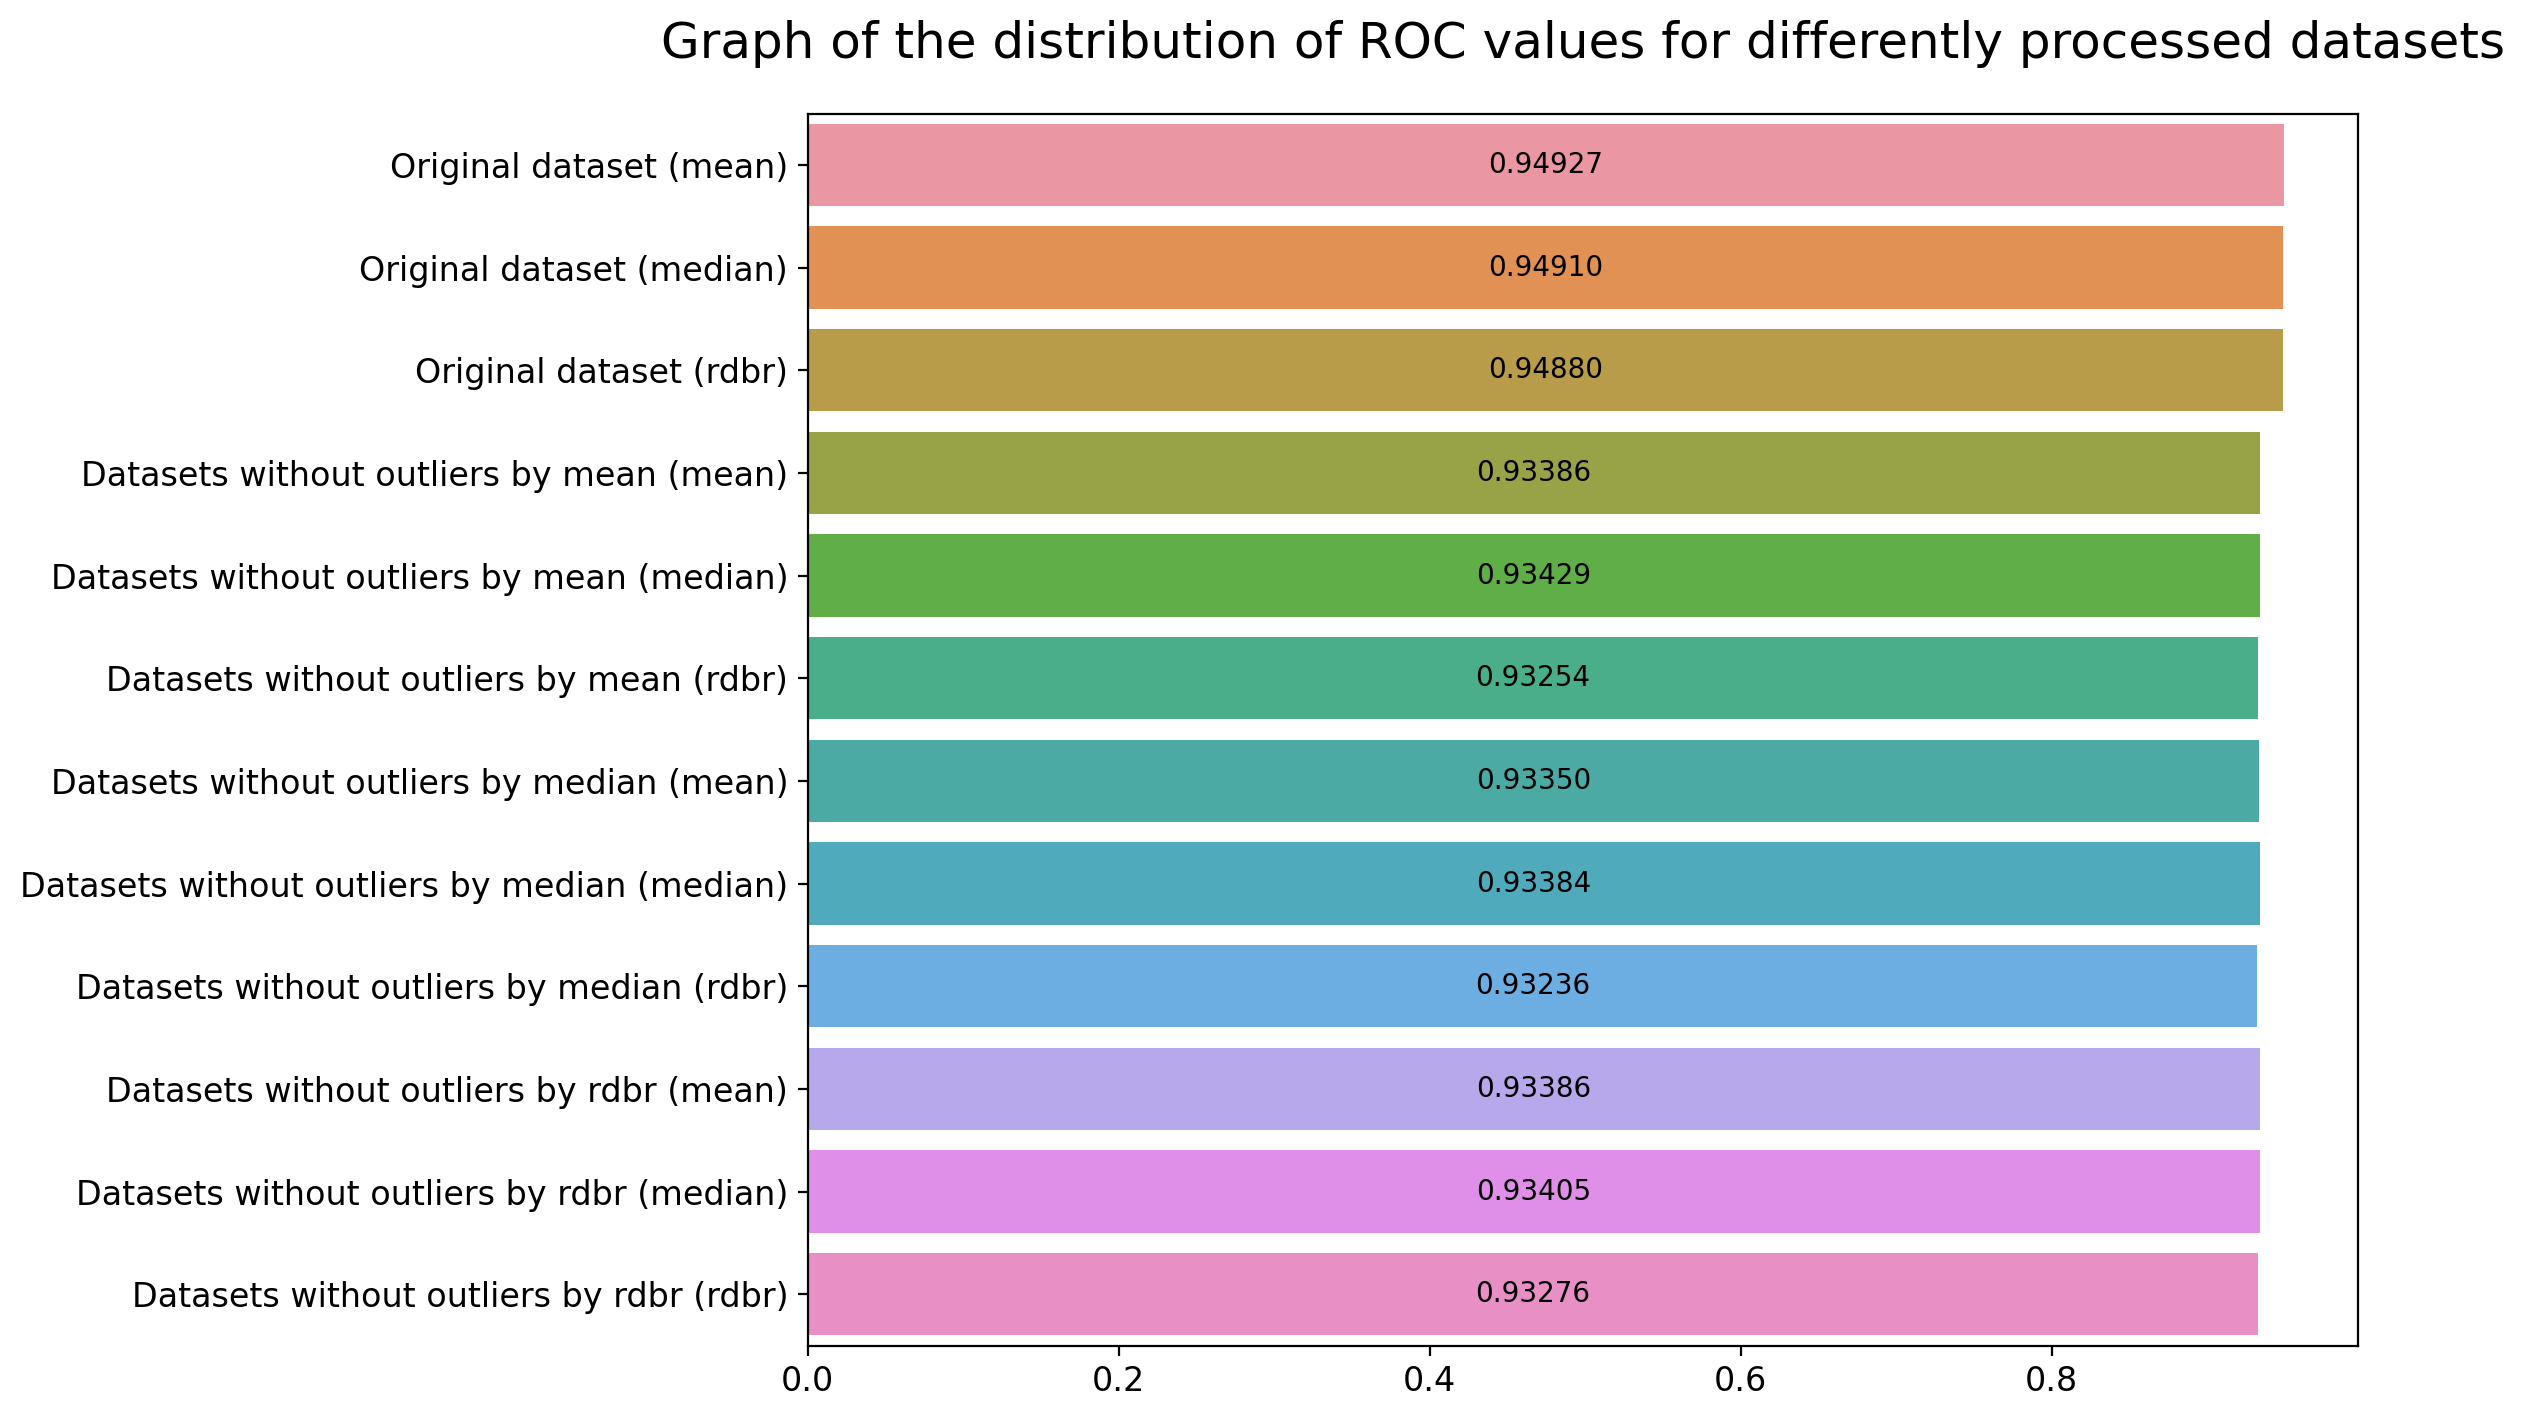

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=200)

sns.barplot(x=metrics, y=names)

ax.bar_label(ax.containers[0], fmt='%.5f', label_type='center')
ax.set_title(
    'Graph of the distribution of ROC values for differently processed datasets',
    fontsize=18, pad=20)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.show()

I bet on RDBR... the bet didn't work :(

It is noteworthy that the leaders of this study are unrefined datasets. And the leader among them is the data set, the nans of which were filled by the mean, which is sensitive to outliers, unlike the median. All this suggests that there are no outliers in the data. At least the ones that actually are. Since by using the interquartile range to remove outliers, we could only get rid of extreme values. But perhaps they were significant in order for the client to go into default.

Generally speaking about the topic of emissions, it is worth saying here that this is always a creative approach. Here always need to examine each feature separately for outliers and understand the specifics of the data, as well as correctly define the task.

We could also use IsolationForest to try to track anomalies in the data, but we will leave this idea for later.

It is also possible that by using PCA, we found only strong linear relationships and thus reduced to almost one pattern, thereby making the results similar to each other. We will check this in the next chapter, since in it we need not only to determine the optimal model, but also to check the Colab hardware for stability in training the model on such a large number of features. We need this to evaluate the importance of features. With the PCA method, this is not possible.

### 2.2.0. Checkpoint

In [ ]:
# Save the best processed datasets

drive.mount('/content/gdrive')
shutil.move('/content/saved/train_original_mean.pkl', '/content/gdrive/MyDrive/')
shutil.move('/content/saved/test_original_mean.pkl', '/content/gdrive/MyDrive/')

Mounted at /content/gdrive


'/content/gdrive/MyDrive/test_original_mean.pkl'

# 3. Machine Learning

## 3.1. Search for the best model

### 3.1.0. Start from checkpoint

In [ ]:
# Download the best processed train dataset
!gdown --quiet 1mbmF83S9ix_Q0LV65kazRBIkPtMN5LOP

In [ ]:
# Install CatBoost

!pip --quiet install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.2 MB/s eta 0:00:00


In [ ]:
# Install Shap

!pip --quiet install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 5.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import fbeta_score, roc_auc_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

In [ ]:
# Dataset initialization

df_train = pd.read_pickle('/content/train_original_mean.pkl')

### 3.1.1. Train defferent models

In contrast to the previous chapter, in this one we will not use PСA, but we will still compare models without parameter selection. We will compare so to speak out of the box. It's faster and doesn't distort the result too much. Consider the following models: LogisticRegression, RandomForest, LightGBM, CatBoost and XGBoost.

In [ ]:
# We will add the results of each work with name of the model to these lists.
models = []
metrics = []

# Value for random
SEED = 14

In [ ]:
# Split df_train

X = df_train.drop(columns='target')
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y,
                                                    random_state=SEED)

In [ ]:
# LogisticRegression

%%time

LG_model = LogisticRegression(random_state=SEED)
LG_model.fit(X_train, y_train)

LG_y_pred = LG_model.predict_proba(X_test)[:, 1]
metric = roc_auc_score(y_test, LG_y_pred)

models.append('LogisticRegression')
metrics.append(metric)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


CPU times: user 17.5 s, sys: 3.05 s, total: 20.5 s
Wall time: 18.6 s


The warning is most likely due to the fact that our categorical features are not normalized. There is nothing critical.

In [ ]:
# RandomForest

%%time

RF_model = RandomForestClassifier(random_state=SEED, n_jobs=-1)
RF_model.fit(X_train, y_train)

RF_y_pred = RF_model.predict_proba(X_test)[:, 1]
metric = roc_auc_score(y_test, RF_y_pred)

models.append('RandomForest')
metrics.append(metric)

CPU times: user 17min 50s, sys: 1.63 s, total: 17min 51s
Wall time: 13min 23s


In [ ]:
# LightGBM

%%time

LGBM_model = LGBMClassifier(random_state=SEED)
LGBM_model.fit(X_train, y_train)

LGBM_y_pred = LGBM_model.predict_proba(X_test)[:, 1]
metric = roc_auc_score(y_test, LGBM_y_pred)

models.append('LightGBM')
metrics.append(metric)

CPU times: user 42.1 s, sys: 962 ms, total: 43.1 s
Wall time: 43.1 s


In [ ]:
# XGBoost

%%time

XGB_model = XGBClassifier(random_state=SEED)
XGB_model.fit(X_train, y_train)

XGB_y_pred = XGB_model.predict_proba(X_test)[:, 1]
metric = roc_auc_score(y_test, XGB_y_pred)

models.append('XGBoost')
metrics.append(metric)

CPU times: user 8min 49s, sys: 1.56 s, total: 8min 51s
Wall time: 9min


In [ ]:
# CatBoost

%%time

CB_model = CatBoostClassifier(random_state=SEED, verbose=False)
CB_model.fit(X_train, y_train)

CB_y_pred = CB_model.predict_proba(X_test)[:, 1]
metric = roc_auc_score(y_test, CB_y_pred)

models.append('CatBoost')
metrics.append(metric)

CPU times: user 7min 2s, sys: 2.62 s, total: 7min 5s
Wall time: 4min 10s


#### 3.1.1.1. The result

To see at the result.

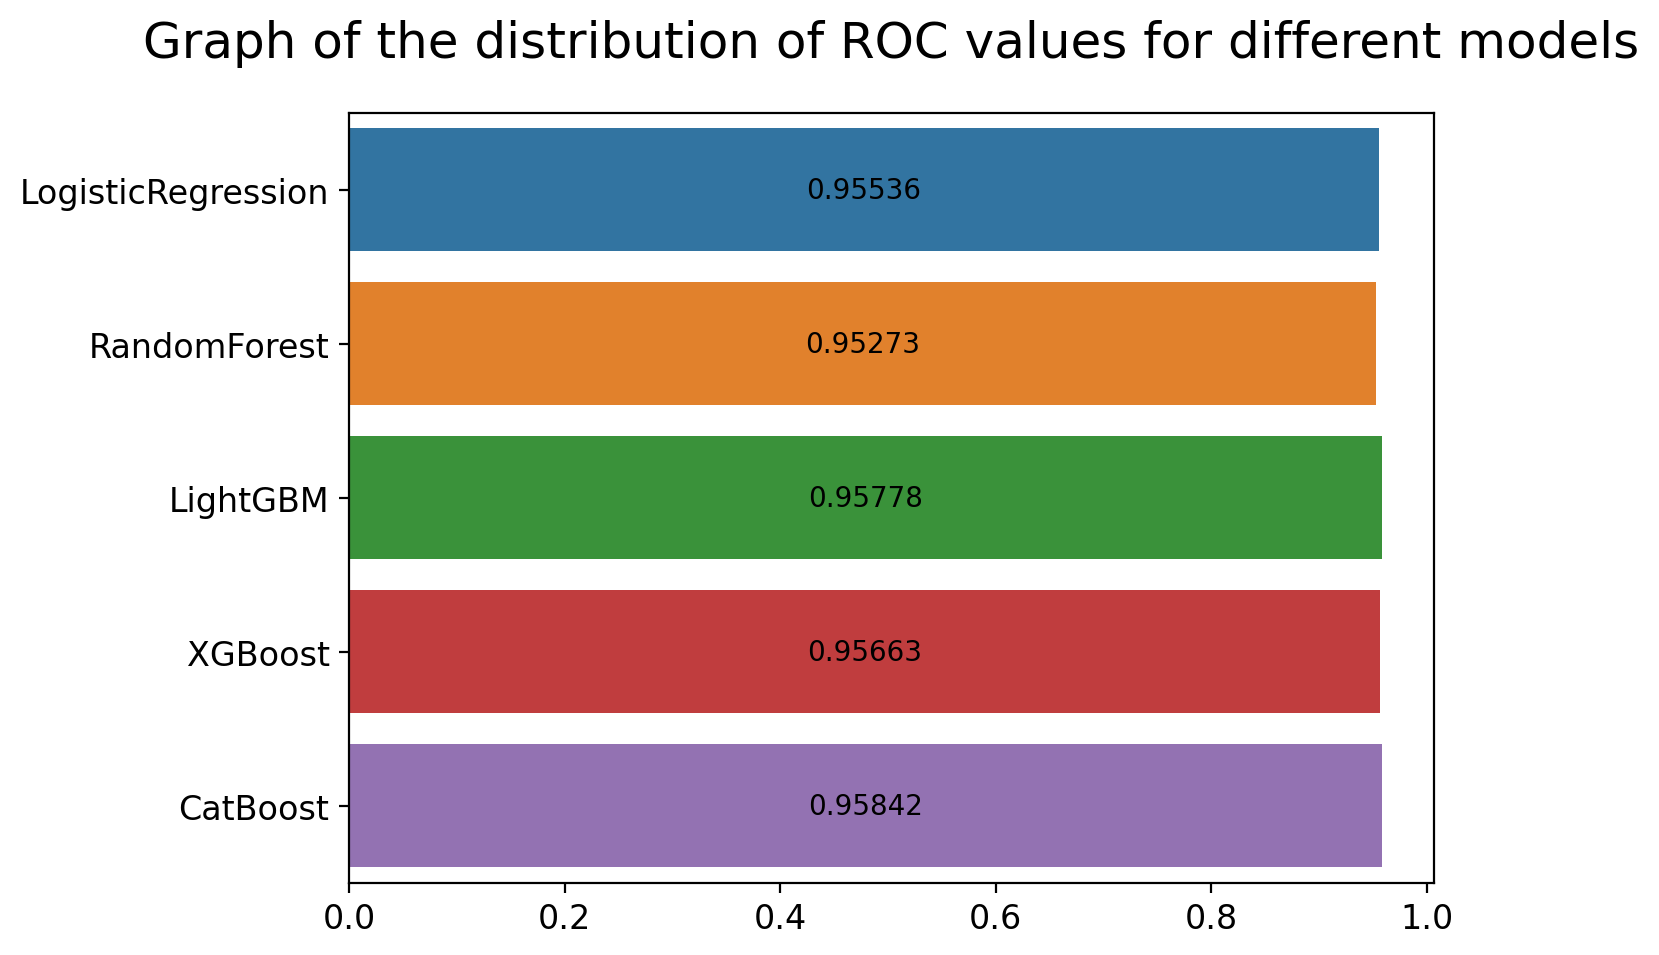

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=200)

sns.barplot(x=metrics, y=models)

ax.bar_label(ax.containers[0], fmt='%.5f', label_type='center')
ax.set_title(
    'Graph of the distribution of ROC values for different models',
    fontsize=18, pad=20)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.show()

Even the usual logistic regression shows a good result. This clearly tells us that the data is linearly dependent. This clearly tells us that the data is linearly dependent. The best way to see this is without plotting the correlation.

We could not build it at the beginning of the work, since there are a lot of signs. In order for the graph to display normally, it must be the size of a football field. It is possible to build it after the PСA, but the information content about which signs correlate with each other will be lost, and the method itself is linear, which will distort the result of the graph.

Let's get back to the results. What if we apply bagging method to these models, take all the predictions and average them? Let's check if this approach can beat the result of the leader - CatBoost (0.95842).

In [ ]:
mean_y_pred = (LG_y_pred + RF_y_pred + LGBM_y_pred + CB_y_pred + XGB_y_pred) / 5

print('ROC-AUC by mean predict of all models: {}'
      .format(roc_auc_score(y_test, mean_y_pred)))

ROC-AUC by mean predict of all models: 0.9586588898503973


Broke the record! Let's add values to our lists.

In [ ]:
models.append('MeanOfModels')
metrics.append(roc_auc_score(y_test, mean_y_pred))

It is interesting to look at the results of other metrics. Consider them on the example of our new leader. To begin with, we will use 0.65 threshold for the metrics, but then we'll see.

In [ ]:
threshold = 0.65

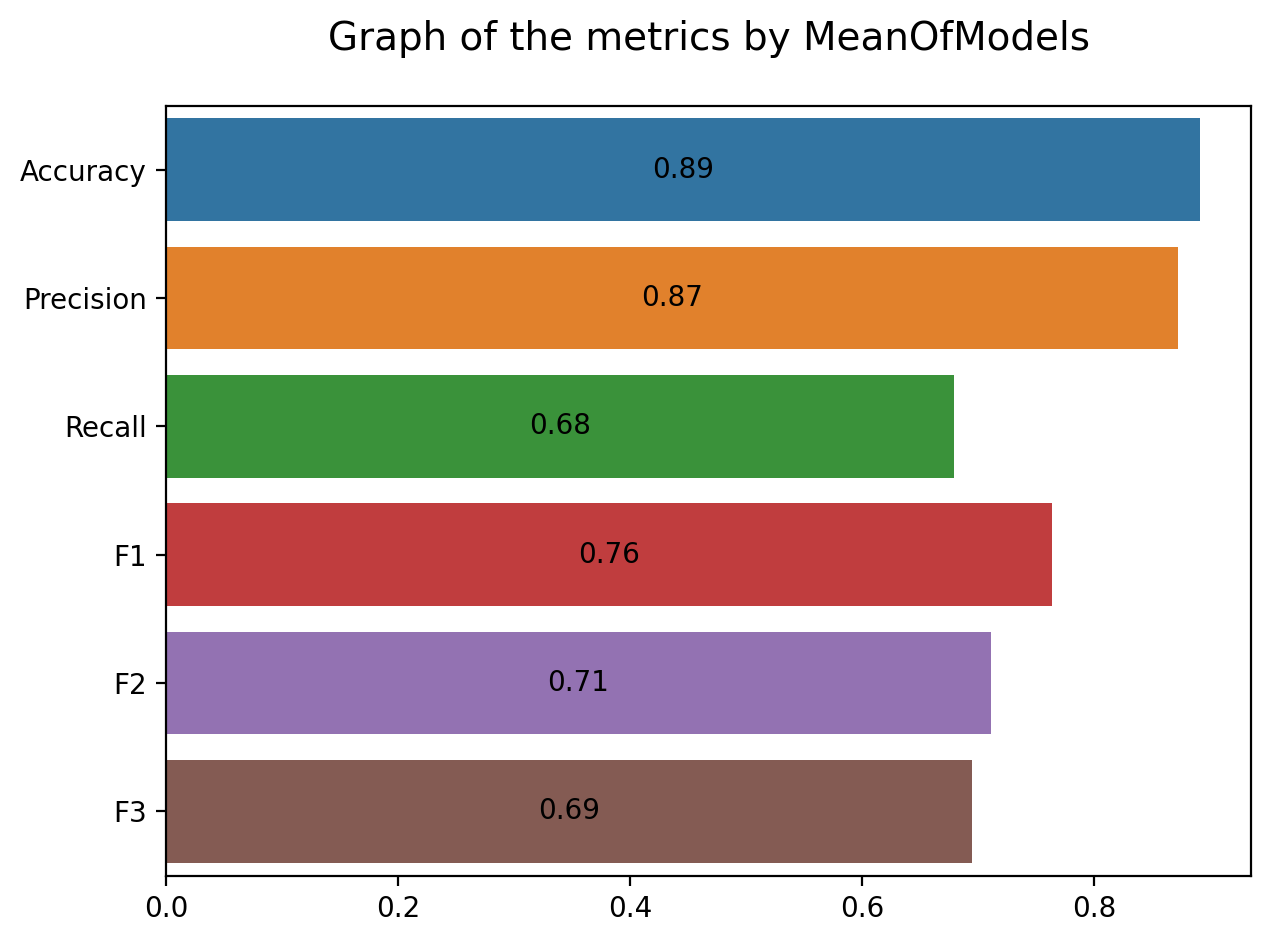

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=200)

name_metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'F2', 'F3']
scores = [
    accuracy_score(y_test, mean_y_pred > threshold),
    precision_score(y_test, mean_y_pred > threshold),
    recall_score(y_test, mean_y_pred > threshold),
    fbeta_score(y_test, mean_y_pred > threshold, beta=1),
    fbeta_score(y_test, mean_y_pred > threshold, beta=2),
    fbeta_score(y_test, mean_y_pred > threshold, beta=3)
    ]

sns.barplot(x=scores, y=name_metrics)

ax.bar_label(ax.containers[0], fmt='%.2f', label_type='center')
ax.set_title('Graph of the metrics by MeanOfModels', fontsize=14, pad=20)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

plt.show()

In general, everything is fine. It is worth noting that everything depends on the threshold. It is clear why the organizers chose ROC-AUC.

Accuracy is clearly not equal to the share of the majority class, which means that we do not have overfitting.

If the error of the second kind is critical, then it is better to improve Recall.


### 3.1.2. Stacking different models

Now let's try stacking. Final estimator is CatBoost, because it was leader previously.

In [ ]:
# Stacking

%%time

estimators = [
     ('lg', LG_model),
     ('rf', RF_model),
     ('lgbm', LGBM_model),
     ('xgb', XGB_model)
]
stacking_model = StackingClassifier(estimators=estimators,
                                    final_estimator=CB_model,
                                    n_jobs=-1)

stacking_model.fit(X_train, y_train)

stacking_y_pred = stacking_model.predict_proba(X_test)[:, 1]
metric = roc_auc_score(y_test, stacking_y_pred)

models.append('Stacking')
metrics.append(metric)

Accidentally deleted output. The model trained for 1:37 hours.

Let's average the stacking result with the results of all models and with MeanOfModels.

In [ ]:
# Averages
mean_stack_models_y_pred = (stacking_y_pred + LG_y_pred + RF_y_pred
                     + LGBM_y_pred + CB_y_pred + XGB_y_pred) / 6
mean_stack_mom_y_pred = (stacking_y_pred + mean_y_pred) / 2

# Appending to lists
models.append('MeanStacking&Models')
metrics.append(roc_auc_score(y_test, mean_stack_models_y_pred))
models.append('MeanStacking&MeanOfModels')
metrics.append(roc_auc_score(y_test, mean_stack_mom_y_pred))

#### 3.1.2.1. The result

Let's look at the result.

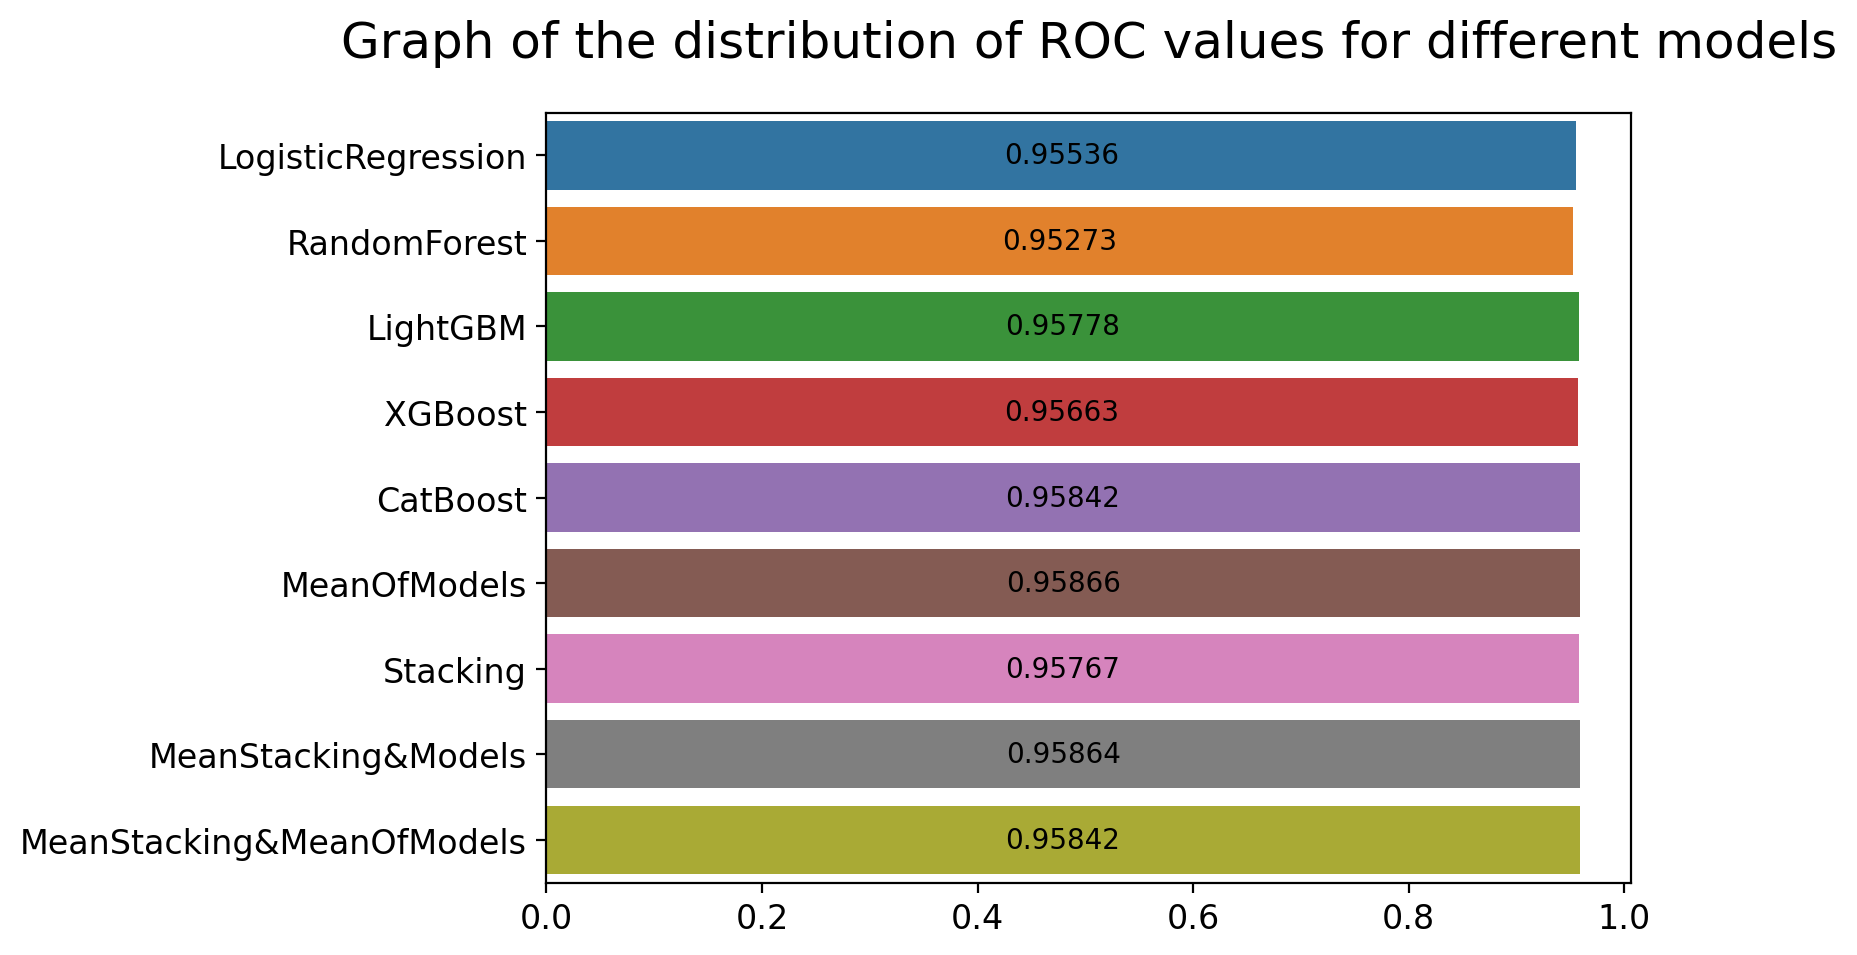

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=200)

sns.barplot(x=metrics, y=models)

ax.bar_label(ax.containers[0], fmt='%.5f', label_type='center')
ax.set_title(
    'Graph of the distribution of ROC values for different models',
    fontsize=18, pad=20)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.show()

Staking did not justify itself neither in terms of value or in terms of speed. Averaging with other models helped improve the result a bit. The result of "averaging with averaging" increased a little worse. It is understandable why this is so - this is an incorrect averaging. However, even with the correct averaging, it was not possible to overtake the previous averaging (0.00002 difference). What else remains to try is to pick up the hyperparameters from the leader (CatBoost) and average with other models with no griding on parameters.

Let's get started.

### 3.1.3. Search hyperparameters

In [ ]:
# Init grid

grid = {
    'learning_rate': [3e-4, 0.03, 0.1],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
    }

In [ ]:
# RandomSearch hyperparameters for CatBoost model

%%time

RS_CB_model = CatBoostClassifier(random_state=SEED, verbose=False)

randomized_search_result = RS_CB_model.randomized_search(
    grid,
    X=X_train,
    y=y_train,
    stratified=True,
    n_iter=10,
    cv=5,
    partition_random_seed=SEED,
    verbose=100
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.4657817921
bestIteration = 999

0:	loss: 0.4657818	best: 0.4657818 (0)	total: 2m 58s	remaining: 26m 47s

bestTest = 0.2302022939
bestIteration = 999


bestTest = 0.2280613671
bestIteration = 941


bestTest = 0.4652826527
bestIteration = 999


bestTest = 0.2284356654
bestIteration = 998


bestTest = 0.2282988116
bestIteration = 679


bestTest = 0.4493092204
bestIteration = 999


bestTest = 0.228463083
bestIteration = 994


bestTest = 0.2313726155
bestIteration = 166


bestTest = 0.2283446703
bestIteration = 998

9:	loss: 0.2283447	best: 0.2280614 (2)	total: 1h 28m 46s	remaining: 0us
Estimating final quality...
Training on fold [0/5]

bestTest = 0.2256652029
bestIteration = 999

Training on fold [1/5]

bestTest = 0.2248513091
bestIteration = 977

Training on fold [2/5]

bestTest = 0.2239986647
bestIteration = 996

Training on fold [3/5]

bestTest = 0.2231597131
bestIteration = 991

Training on fold [4/5]

bestTest = 0.2284635754
bestIteration = 963

CPU times: user 2h 51min

In [ ]:
# Training and predict

%%time

RS_CB_model.fit(X_train, y_train)

RS_CB_y_pred = RS_CB_model.predict_proba(X_test)[:, 1]
metric = roc_auc_score(y_test, RS_CB_y_pred)

models.append('RS_CatBoost')
metrics.append(metric)

I forgot to write the '%%time', but the code took 3 minutes to complete, which is less than the last time CatBoost model was trained.

In [ ]:
# Already a favorite averaging procedure :) Do it

mean_y_pred = ((LG_y_pred + RF_y_pred + LGBM_y_pred + XGB_y_pred + RS_CB_y_pred)
              / 5)

models.append('MeanOfModelsWithRS_CatBoost')
metrics.append(roc_auc_score(y_test, mean_y_pred))

Let's thank Colab for the failure :) Fortunately, I managed to make a graph, and using it I can manually restore the values of the metrics.

Let's continue to explore with the help of GridSearch.

In [ ]:
# Restore

saved_models = ['Stacking', 'MeanStacking&Models', 'MeanStacking&MeanOfModels',
                'RS_CatBoost', 'MeanOfModelsWithRS_CatBoost']
saved_metrics = [0.95767, 0.95864, 0.95842, 0.95864, 0.95857]

for i in saved_models:
  models.append(i)
for i in saved_metrics:
  metrics.append(i)

In [ ]:
# GridSearch hyperparameters for CatBoost model

%%time

GS_CB_model = CatBoostClassifier(random_state=SEED, verbose=False)

grid_search_result = GS_CB_model.grid_search(
    grid,
    X=X_train,
    y=y_train,
    stratified=True,
    cv=5,
    partition_random_seed=SEED,
    verbose=True
    )


bestTest = 0.4657817921
bestIteration = 999

0:	loss: 0.4657818	best: 0.4657818 (0)	total: 3m 5s	remaining: 2h 16m 15s

bestTest = 0.2302022939
bestIteration = 999

1:	loss: 0.2302023	best: 0.2302023 (1)	total: 5m 33s	remaining: 1h 59m 38s

bestTest = 0.2281859105
bestIteration = 986

2:	loss: 0.2281859	best: 0.2281859 (2)	total: 8m 12s	remaining: 1h 54m 50s

bestTest = 0.4656003051
bestIteration = 999

3:	loss: 0.4656003	best: 0.2281859 (2)	total: 11m 49s	remaining: 2h 1m 16s

bestTest = 0.2301649498
bestIteration = 998

4:	loss: 0.2301649	best: 0.2281859 (2)	total: 15m 31s	remaining: 2h 4m 10s

bestTest = 0.2284931407
bestIteration = 950

5:	loss: 0.2284931	best: 0.2281859 (2)	total: 18m 45s	remaining: 2h 1m 58s

bestTest = 0.4656198878
bestIteration = 999

6:	loss: 0.4656199	best: 0.2281859 (2)	total: 22m 39s	remaining: 2h 3m 2s

bestTest = 0.2301218731
bestIteration = 998

7:	loss: 0.2301219	best: 0.2281859 (2)	total: 26m 16s	remaining: 2h 1m 30s

bestTest = 0.2280613671
bestItera

KeyboardInterrupt: ignored

Hmm ... What went is not so difficult to say. After 3 hours, I had to stop the execution of the code. Everything seemed to be coming to an end, but the remaining time began to increase, and with it the loss. GridSearch itself is a very long process, especially for large datasets, and we have just a lot of signs. Perhaps, going through all the options, GridSearch broke the Colab processors. 😆

In theory, the results of the selection should have been preserved. Let's see it.

In [ ]:
# Training and predict

%%time

GS_CB_model.fit(X_train, y_train)

GS_CB_y_pred = GS_CB_model.predict_proba(X_test)[:, 1]
metric = roc_auc_score(y_test, GS_CB_y_pred)

models.append('GS_CatBoost')
metrics.append(metric)

CPU times: user 7min 6s, sys: 2.67 s, total: 7min 8s
Wall time: 4min 15s


In [ ]:
# Average

mean_y_pred = ((LG_y_pred + RF_y_pred + LGBM_y_pred + XGB_y_pred + GS_CB_y_pred)
              / 5)

models.append('MeanOfModelsWithGS_CatBoost')
metrics.append(roc_auc_score(y_test, mean_y_pred))

#### 3.1.3. The results

Let's look at the results.

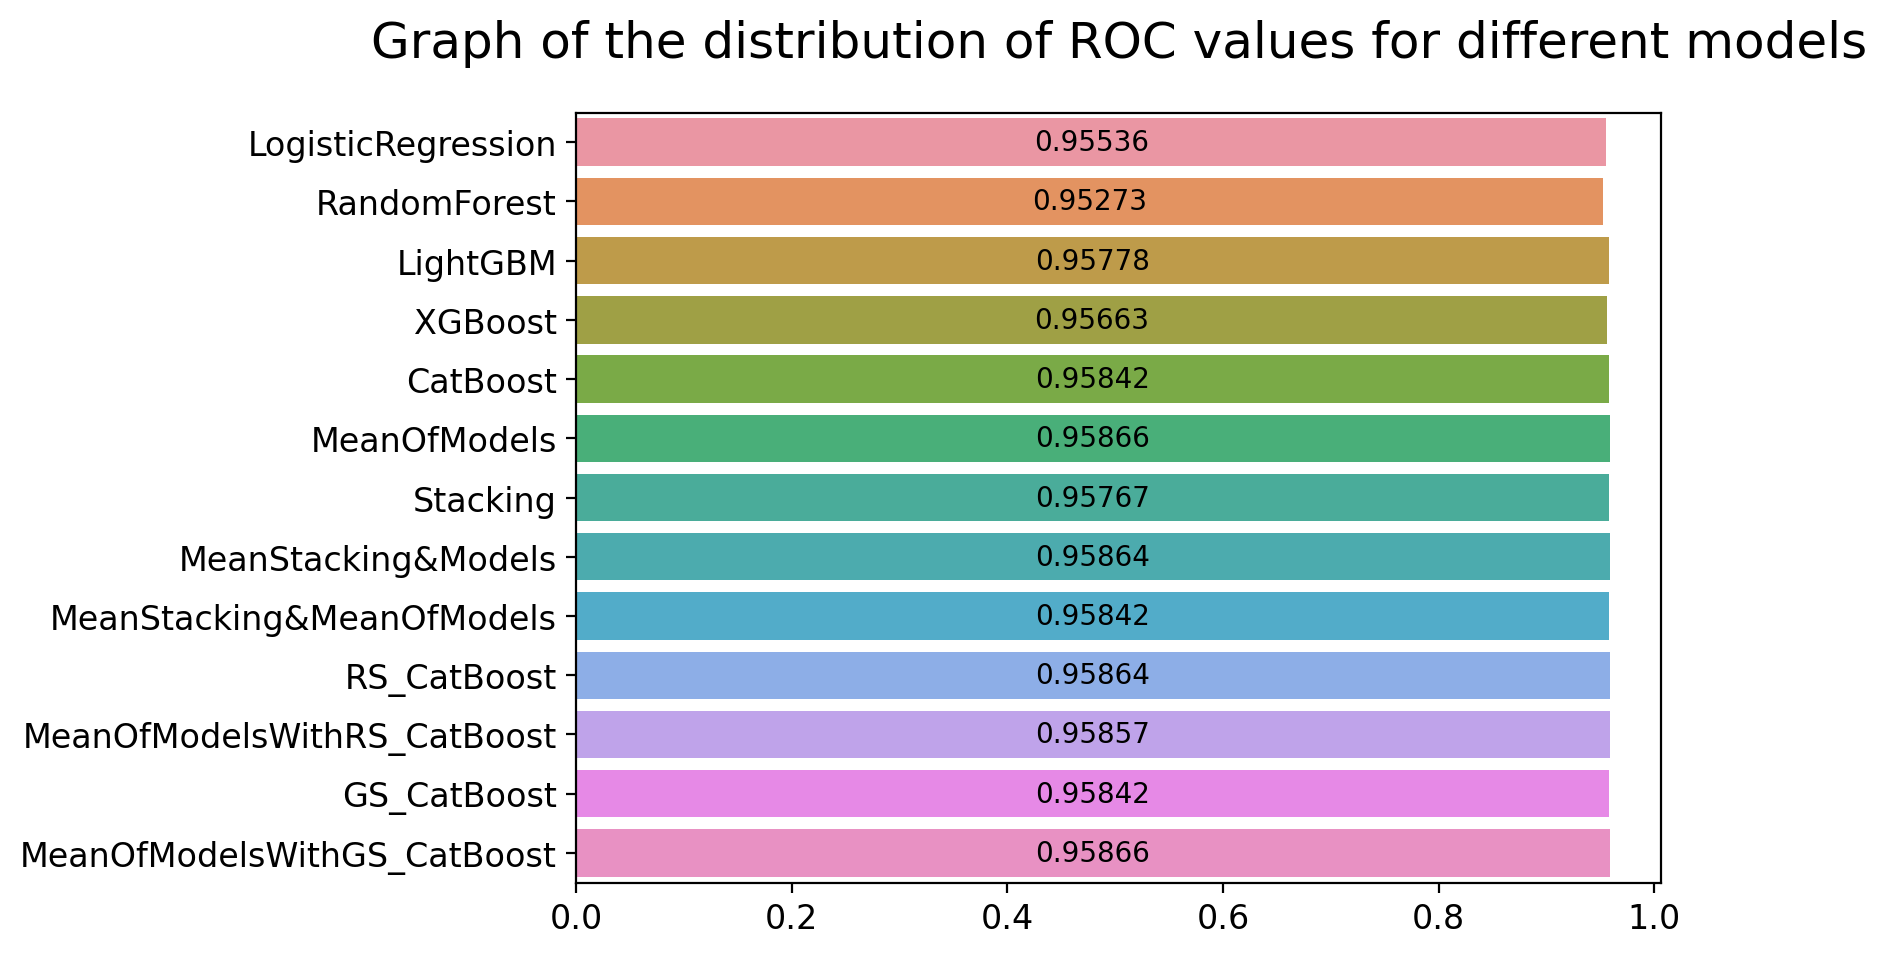

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=200)

sns.barplot(x=metrics, y=models)

ax.bar_label(ax.containers[0], fmt='%.5f', label_type='center')
ax.set_title(
    'Graph of the distribution of ROC values for different models',
    fontsize=18, pad=20)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.show()

Most likely, GridSearch saves data only when it completes its work, since the result is the same with CatBust without enumeration of parameters. The same applies to averaging - it is one to one.

As for the whole study on which model and approach to choose, the most optimal thing is what we did at the beginning: train five models, and then average them. In fact, this approach turned out to be the strongest, even RandomSearch could not break the record, although it was close. But even if he broke this record, you need to think about the appropriateness of such an event, because often time is money. I wonder what result GridSearch would give, but, most likely, it would not have advanced far, but it would have spent a lot of time on its execution.

All these records, of course, with a difference of 4 zeros after the dot. But still, we did a good study comparing different models and approaches. Now it remains to use the acquired knowledge for prediction. But before that, let's take a look at the importance of features.

### 3.1.4. Feature importance

#### 3.1.4.1. Built-in method

In [ ]:
feat_imp = sorted(zip(X_train.columns,
                      CB_model.feature_importances_),
                  key=lambda x: -x[1])
top = np.array(feat_imp[:15])

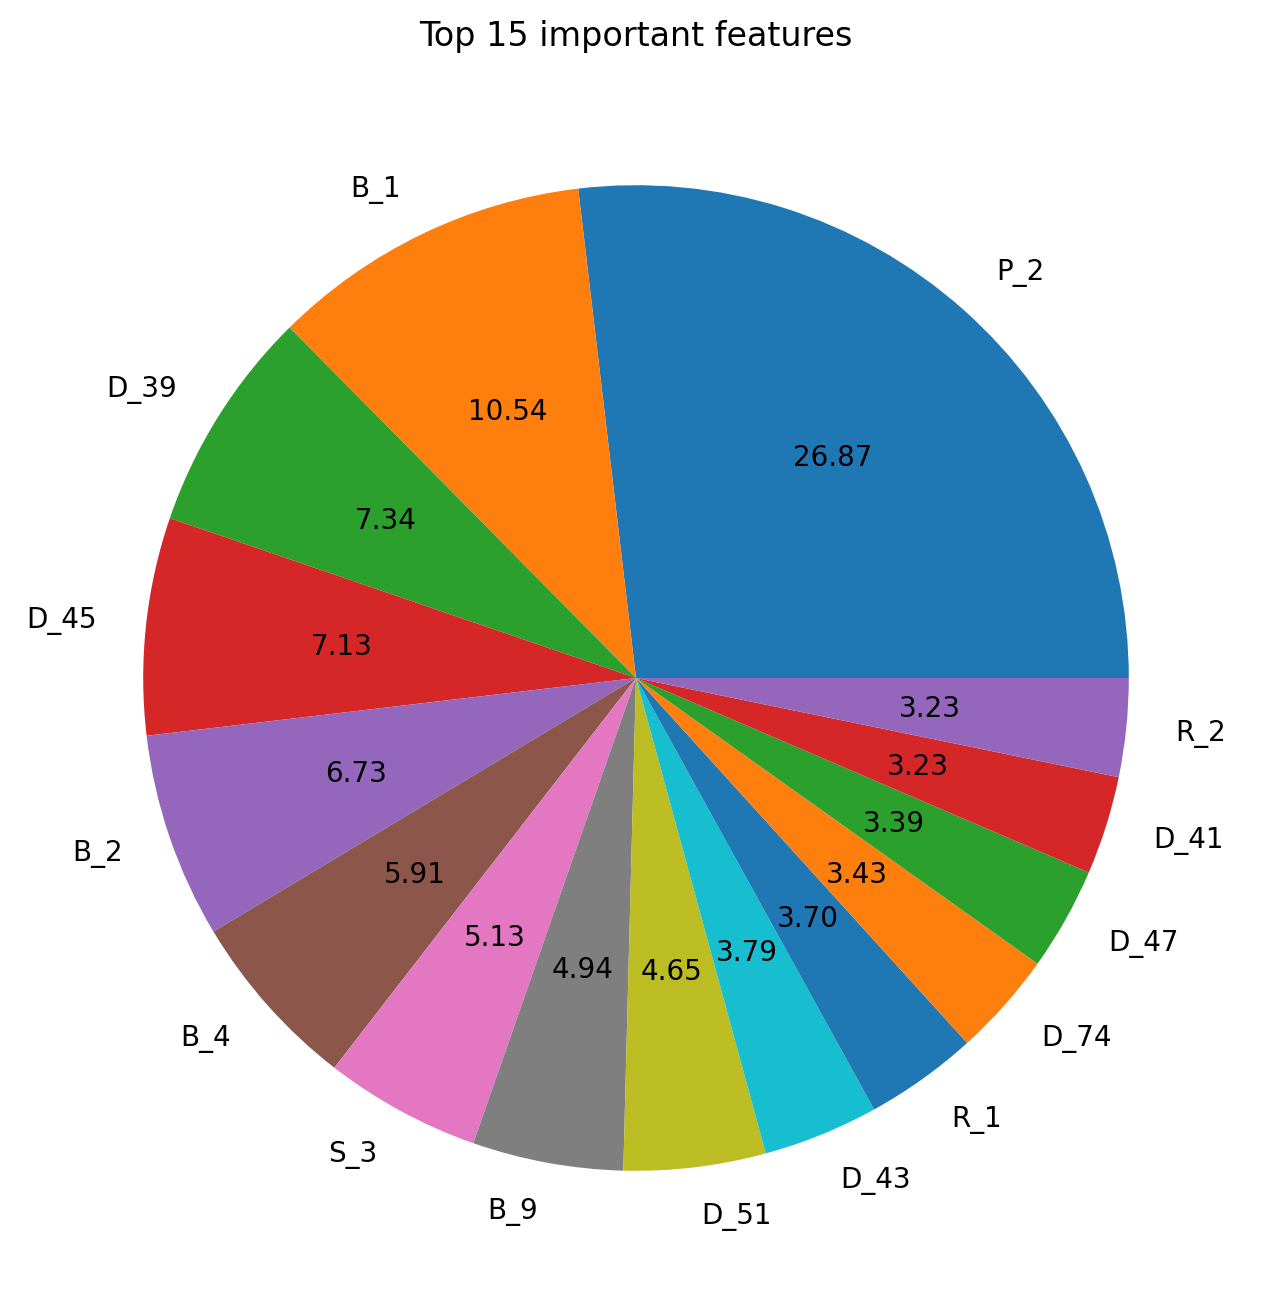

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=200)

exp = [.2, .1, .07, .05, .04, .04, .03, .03, .02, .02]

ax.pie(top[:15, 1], labels=top[:15, 0], autopct='%.2f',
        radius=1)
ax.set_title('Top 15 important features', y=1, 
             fontdict={'fontsize': 12})

plt.show()

#### 3.1.4.2. Shap

In [ ]:
explainer = shap.TreeExplainer(CB_model)
shap_values = explainer.shap_values(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


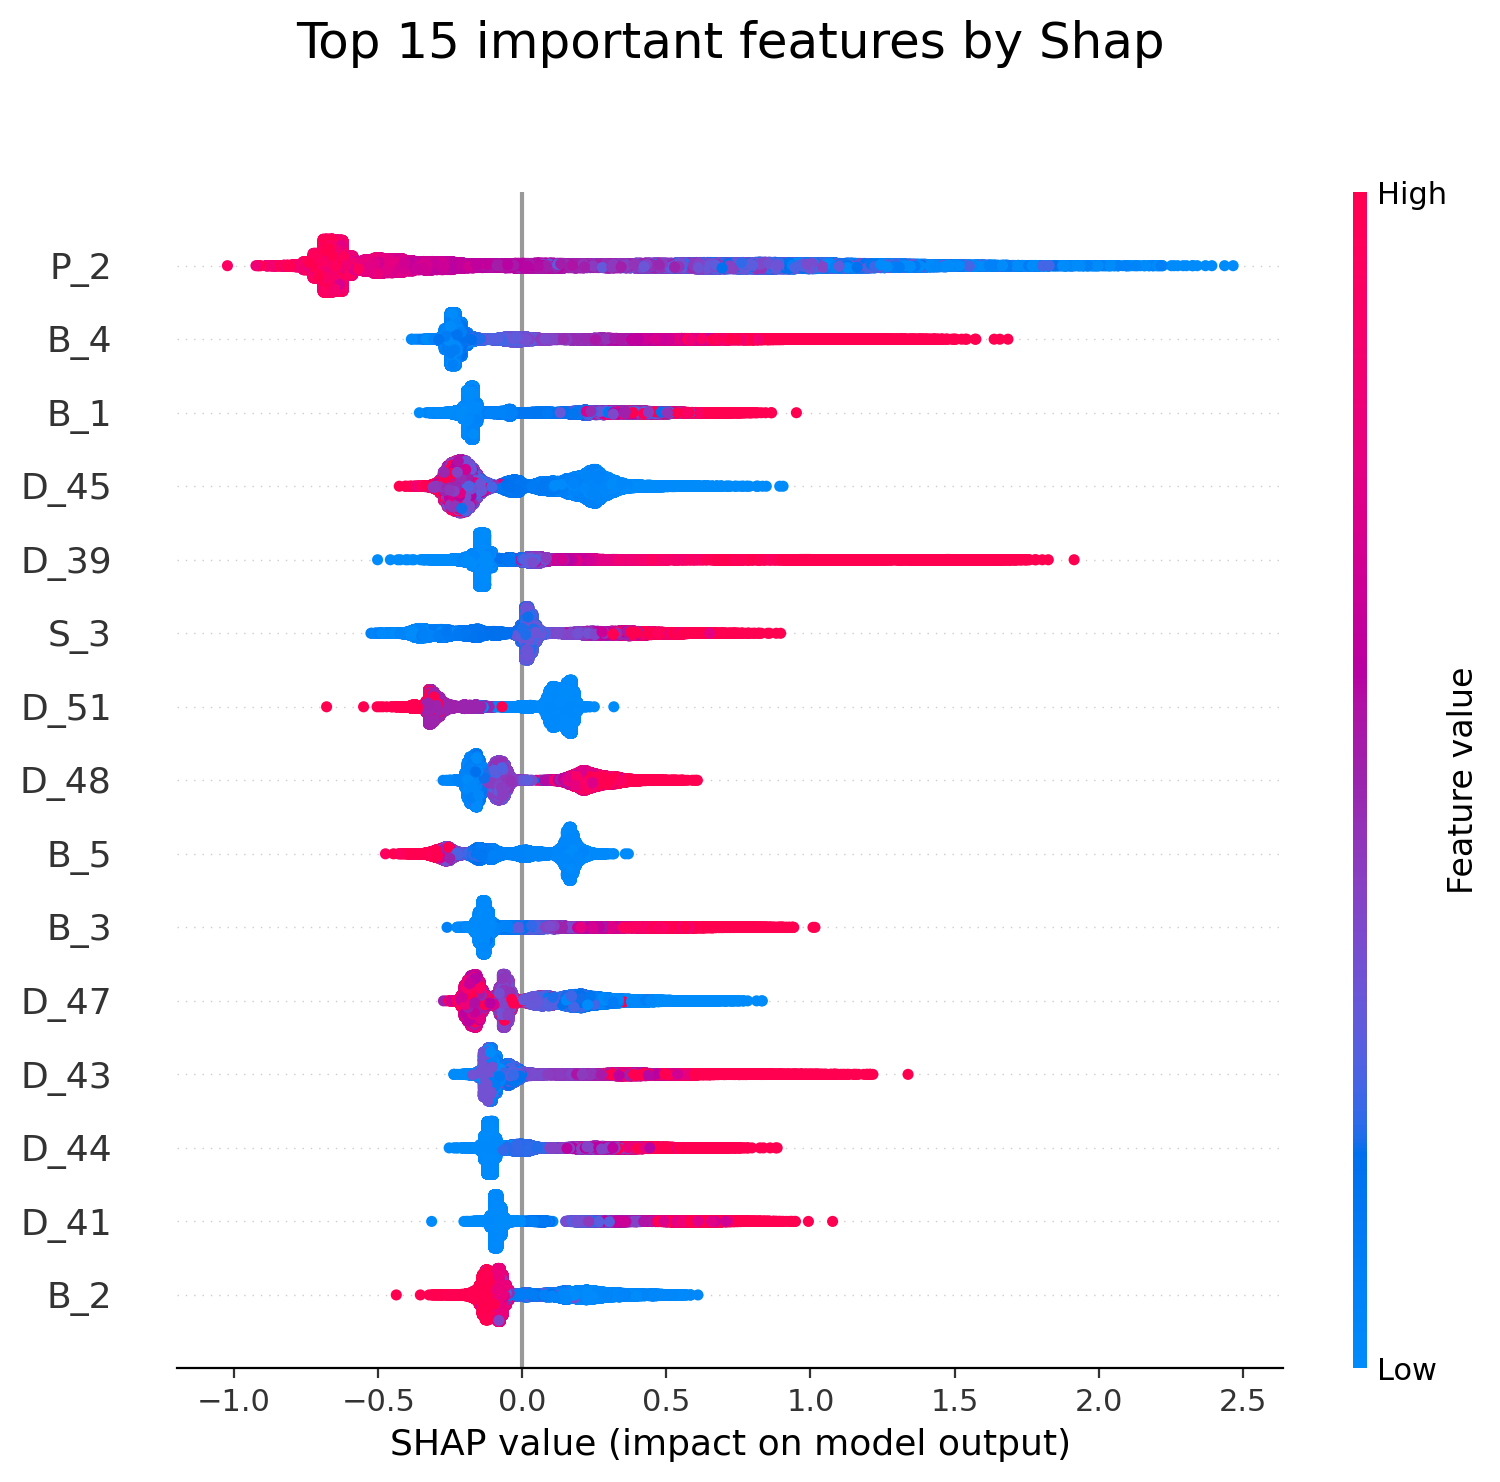

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=200)

ax.set_title('Top 15 important features by Shap', y=1.1, 
             fontdict={'fontsize': 18})

shap.summary_plot(shap_values, X_test, max_display=15)

plt.show()

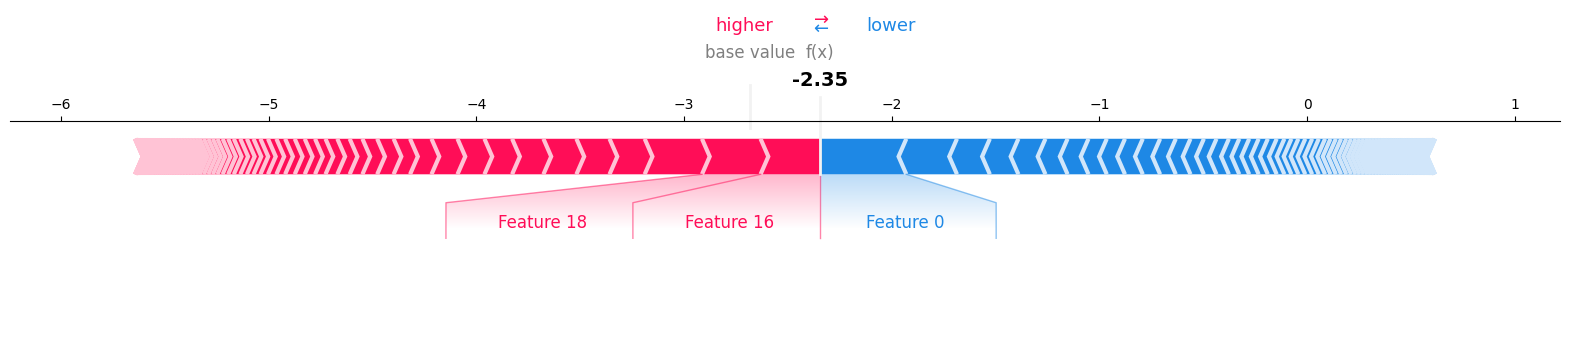

In [ ]:
# For 4-th object

shap.force_plot(explainer.expected_value, shap_values[3], matplotlib=True)

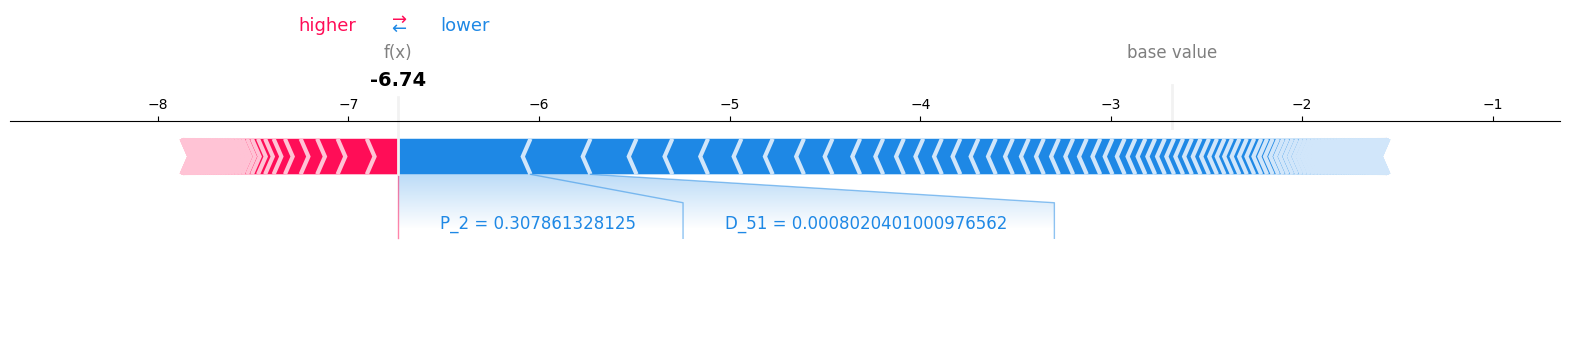

In [ ]:
# For 13-th object

shap.force_plot(explainer.expected_value, shap_values[0],
                X_test.iloc[12], matplotlib=True)

#### 3.1.4.3. Conclusion

The leader in the importance of features is P_2. It is available in two approaches. It can be assumed that P_2 is a payment in a certain period of time. If there are no payments during this period of time for a long time, then the client either has problems with money, or he has ceased to be a client of some bank. Her only oddity is that in the top it is one of a kind (letter P). After all, there were P_3 and P_4.

The remaining signs diverge according to the methods. But we can distinguish the most common ones by the first letter:
* D - occurs 7 times in the Built-in method, 8 times in the Shap:
  * D - Delinquency. That says it all. It's amazing why it's not in the first place. Most likely, the assumption about P_2 was erroneous.
* B - occurs 4 times in the Built-in method, 5 times in the Shap:
  * B - Balance. It is quite logical that this is the case.
* S - occurs 1 time in the Built-in method, 1 time in the Shap:
  * S - Spend. They play some role, but less than others. Most likely, like P_2, it describes the activity of the client, which somehow shows what payment transactions he makes.
* R - occurs 2 times in the Built-in method, never in the Shap:
  * R - Risk. It occupies a smaller role, and in the Shap method it does not matter at all. This is weird. It would seem that risks should somehow have a stronger effect on the client's default. But most likely, the problem is that the risks could be assessed by people, respectively, there is a human factor, or a poorly built risk assessment model. All this could make these signs have nothing to do with reality.

As for the number at the end, you can assume a lot. Basically, the period or status of this or that state (letters) comes to mind.



## 3.2. Submission

### 3.2.0. Start from checkpoint

In [1]:
# Download the best processed datasets

!gdown --quiet 1mbmF83S9ix_Q0LV65kazRBIkPtMN5LOP
!gdown --quiet 15Y4oZ4-oKlUcyB9F6H6kK9dr2ruoEMCu

In [2]:
# Install CatBoost

!pip --quiet install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 4.9 MB/s eta 0:00:00


In [3]:
import shutil
from google.colab import drive

import pandas as pd

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

SEED = 14

In [4]:
# Initialization X_train, y_train and X_test

X_train = pd.read_pickle('/content/train_original_mean.pkl')
y_train = X_train['target']
X_train.drop(columns='target', inplace=True)
X_test = pd.read_pickle('/content/test_original_mean.pkl')

### 3.2.1. Training and Predictions

We use the best approach, train five models without fitting hyperparameters, and average the predictions.

In [5]:
%%time

# LogisticRegression
LG_model = LogisticRegression(random_state=SEED)
LG_model.fit(X_train, y_train)
LG_y_pred = LG_model.predict_proba(X_test)[:, 1]

# RandomForest
RF_model = RandomForestClassifier(random_state=SEED, n_jobs=-1)
RF_model.fit(X_train, y_train)
RF_y_pred = RF_model.predict_proba(X_test)[:, 1]

# LightGBM
LGBM_model = LGBMClassifier(random_state=SEED)
LGBM_model.fit(X_train, y_train)
LGBM_y_pred = LGBM_model.predict_proba(X_test)[:, 1]

# XGBoost
XGB_model = XGBClassifier(random_state=SEED)
XGB_model.fit(X_train, y_train)
XGB_y_pred = XGB_model.predict_proba(X_test)[:, 1]

# CatBoost
CB_model = CatBoostClassifier(random_state=SEED, verbose=False)
CB_model.fit(X_train, y_train)
CB_y_pred = CB_model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: user 57min 37s, sys: 15.9 s, total: 57min 53s
Wall time: 36min 59s


In [6]:
# Averaging predictions

mean_y_pred = (LG_y_pred + RF_y_pred + LGBM_y_pred + CB_y_pred + XGB_y_pred) / 5

### 3.2.2. Saving Predictions

In [12]:
submission = pd.DataFrame(X_test.index)
submission['score'] = mean_y_pred

submission.to_excel('/content/submission.xlsx', index=False)

drive.mount('/content/gdrive')
shutil.move('/content/submission.xlsx', '/content/gdrive/MyDrive/')

Mounted at /content/gdrive


'/content/gdrive/MyDrive/submission.xlsx'

**Thank you for your attention! :)**